# Análisis Exploratorio y Preparación de Datos

Este notebook documenta el proceso completo de limpieza, transformación y preparación del dataset para modelado predictivo de precios de propiedades tipo Airbnb. Se siguen los siguientes pasos:

1. Revisión de variable objetivo (`Price`) y transformación a logaritmo (`Price_log`)
2. Imputación y limpieza de valores faltantes
3. Codificación de variables categóricas
4. Revisión de colinealidad mediante VIF y ajustes
5. Escalado de variables numéricas
6. Exportación del dataset limpio y listo para modelado

--------------------------------------------

LIBRERIAS

In [82]:
import sys              
import os
import re
import random

import numpy as np
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly 
import plotly.express as px

import scipy  
from scipy import stats
from scipy.stats import zscore

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import IsolationForest
from pathlib import Path

import joblib

VERSIONAMIENTO

In [2]:
print("→ Python        :", sys.version.split()[0])
print("→ pandas        :", pd.__version__)
print("→ numpy         :", np.__version__)
print("→ scikit-learn  :", sklearn.__version__)
print("→ matplotlib    :", matplotlib.__version__)
print("→ seaborn       :", sns.__version__)
print("→ plotly        :", plotly.__version__)
print("→ scipy         :", scipy.__version__)
print("→ statsmodels   :", statsmodels.__version__)
print("→ joblib        :", joblib.__version__)

→ Python        : 3.9.2
→ pandas        : 1.5.3
→ numpy         : 1.26.4
→ scikit-learn  : 1.4.2
→ matplotlib    : 3.7.5
→ seaborn       : 0.13.2
→ plotly        : 5.22.0
→ scipy         : 1.11.4
→ statsmodels   : 0.14.2
→ joblib        : 1.3.2


SEMILLA PARA REPRODUCIBILIDAD

In [3]:
SEED = 999
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

--------------

In [4]:
# Defino la URL del dataset y lo cargo
url = "https://raw.githubusercontent.com/gonzalezulises/airbnb-pricing-ml/refs/heads/main/data/raw/airbnb-listings-extract.csv"

# Creo un único DataFrame principal
df_raw = pd.read_csv(url, sep=';', engine='python', on_bad_lines='skip')

-----------------

EXPLORACIÓN INICIAL

In [5]:
print(f"Dimensiones del dataset: {df_raw.shape}")
print(f"\nPrimeras 5 filas del dataset:")
df_raw.head()

Dimensiones del dataset: (14780, 89)

Primeras 5 filas del dataset:


,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


In [6]:
# Muestro información básica sobre el DataFrame
print("\nResumen de tipos de datos:")
df_info = pd.DataFrame({
    'tipo': df_raw.dtypes,
    'no_nulos': df_raw.count(),
    'nulos': df_raw.isnull().sum(),
    'nulos_%': (df_raw.isnull().sum() / len(df_raw) * 100).round(2),
    'valores_unicos': df_raw.nunique()
})
display(df_info.sort_values('nulos_%', ascending=False).head(10))


Resumen de tipos de datos:


,tipo,no_nulos,nulos,nulos_%,valores_unicos
Has Availability,object,12,14768,99.92,1
Host Acceptance Rate,object,39,14741,99.74,12
Jurisdiction Names,object,227,14553,98.46,12
License,object,349,14431,97.64,316
Square Feet,float64,598,14182,95.95,103
Monthly Price,float64,3561,11219,75.91,586
Weekly Price,float64,3590,11190,75.71,388
Notes,object,5644,9136,61.81,4652
Security Deposit,float64,6256,8524,57.67,124
Interaction,object,8228,6552,44.33,6585


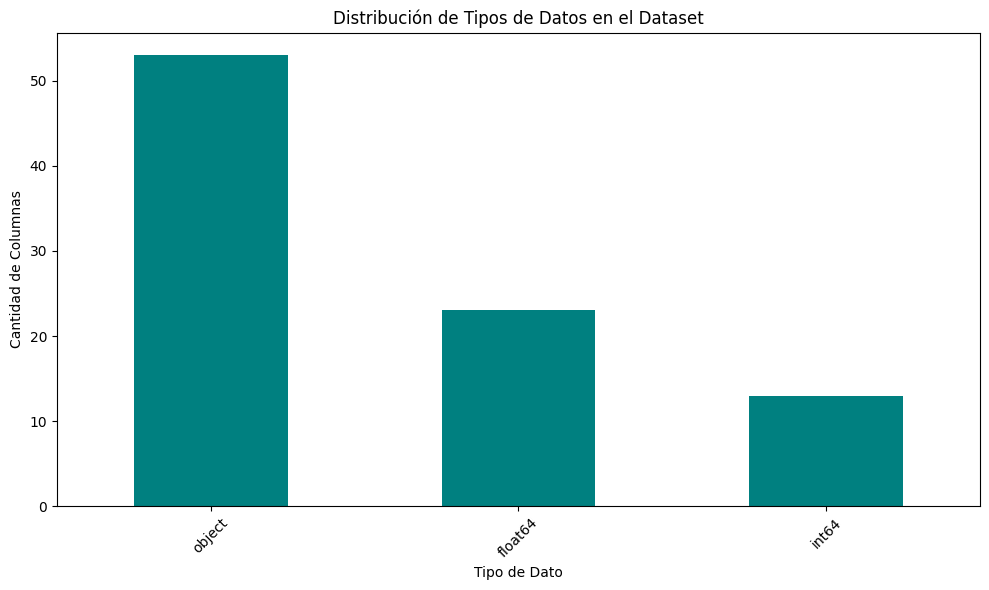

In [7]:
# Visualización: Distribución de tipos de datos en el dataset
plt.figure(figsize=(10, 6))
df_raw.dtypes.value_counts().plot(kind='bar', color='teal')
plt.title('Distribución de Tipos de Datos en el Dataset')
plt.xlabel('Tipo de Dato')
plt.ylabel('Cantidad de Columnas')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

------------------

ANÁLISIS DE TIPOS DE DATOS Y VALORES FALTANTES

In [8]:
# Verifico los tipos de datos
print(df_raw.dtypes.value_counts())

object     53
float64    23
int64      13
dtype: int64


In [9]:
# Analizo valores faltantes
missing_values = df_raw.isnull().sum()
missing_percent = (missing_values / len(df_raw)) * 100
# Creo un DataFrame temporal para visualización, sin almacenarlo en variable
print("Columnas con más de 50% de valores faltantes:")
missing_df = pd.DataFrame({
    'missing_count': missing_values,
    'missing_percent': missing_percent
}).sort_values('missing_percent', ascending=False)
print(missing_df[missing_df['missing_percent'] > 50].head(10))

Columnas con más de 50% de valores faltantes:
                      missing_count  missing_percent
Has Availability              14768        99.918809
Host Acceptance Rate          14741        99.736130
Jurisdiction Names            14553        98.464141
License                       14431        97.638701
Square Feet                   14182        95.953992
Monthly Price                 11219        75.906631
Weekly Price                  11190        75.710419
Notes                          9136        61.813261
Security Deposit               8524        57.672530


In [10]:
# Visualización: Valores faltantes por columna (top 20)
missing_df = pd.DataFrame({
    'missing_count'  : df_raw.isnull().sum(),
    'missing_percent': (df_raw.isnull().sum() / len(df_raw) * 100).round(2)
}).sort_values('missing_percent', ascending=False)

top20 = missing_df.head(20)

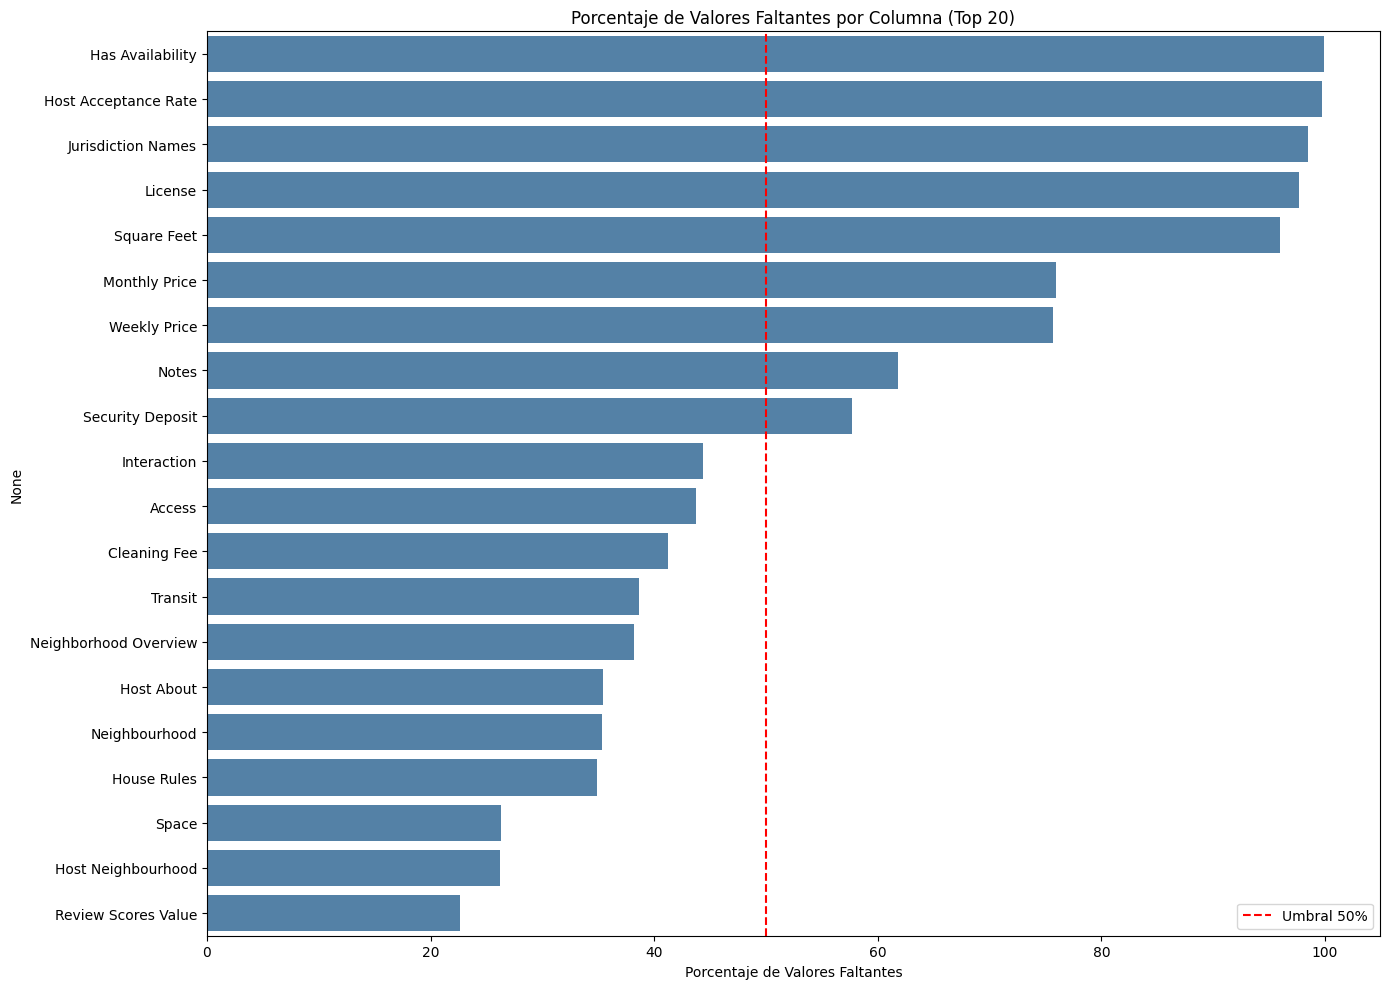

In [11]:
plt.figure(figsize=(14, 10))
sns.barplot(
    x=top20['missing_percent'],
    y=top20.index,
    color='steelblue'
)
plt.title('Porcentaje de Valores Faltantes por Columna (Top 20)')
plt.xlabel('Porcentaje de Valores Faltantes')
plt.axvline(x=50, color='red', linestyle='--', label='Umbral 50%')
plt.legend()
plt.tight_layout()
plt.show()

ANÁLISIS INICIAL DE LA VARIABLE OBJETIVO (PRECIO)

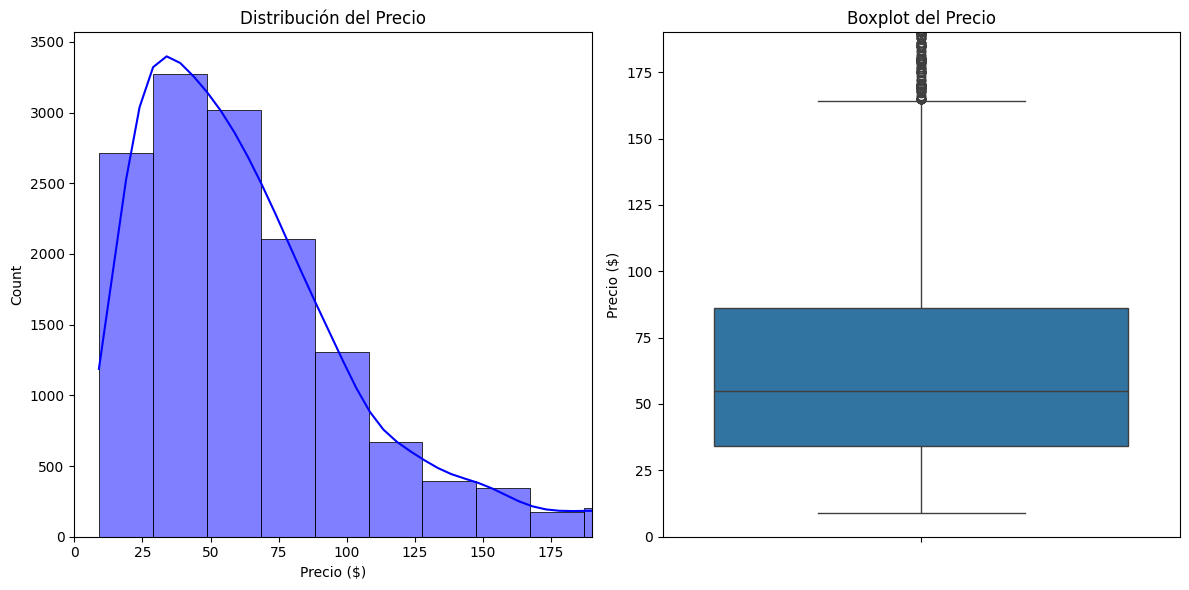

Estadísticas del precio: 
count    14763.000000
mean        73.561471
std         72.062050
min          9.000000
25%         34.000000
50%         55.000000
75%         86.000000
max        999.000000
Name: Price, dtype: float64
Asimetría (skewness): 4.36
Kurtosis: 29.79


In [12]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df_raw['Price'].dropna(), bins=50, kde=True, color='blue')
plt.title('Distribución del Precio')
plt.xlabel('Precio ($)')
plt.xlim(0, df_raw['Price'].quantile(0.95))  # Limito el eje x al percentil 95 para mejor visualización

plt.subplot(1, 2, 2)
sns.boxplot(y=df_raw['Price'].dropna())
plt.title('Boxplot del Precio')
plt.ylabel('Precio ($)')
plt.ylim(0, df_raw['Price'].quantile(0.95))

plt.tight_layout()
plt.show()

print(f"Estadísticas del precio: \n{df_raw['Price'].describe()}")
print(f"Asimetría (skewness): {df_raw['Price'].skew():.2f}")
print(f"Kurtosis: {df_raw['Price'].kurtosis():.2f}")


RELACIONES PRINCIPALES CON EL PRECIO

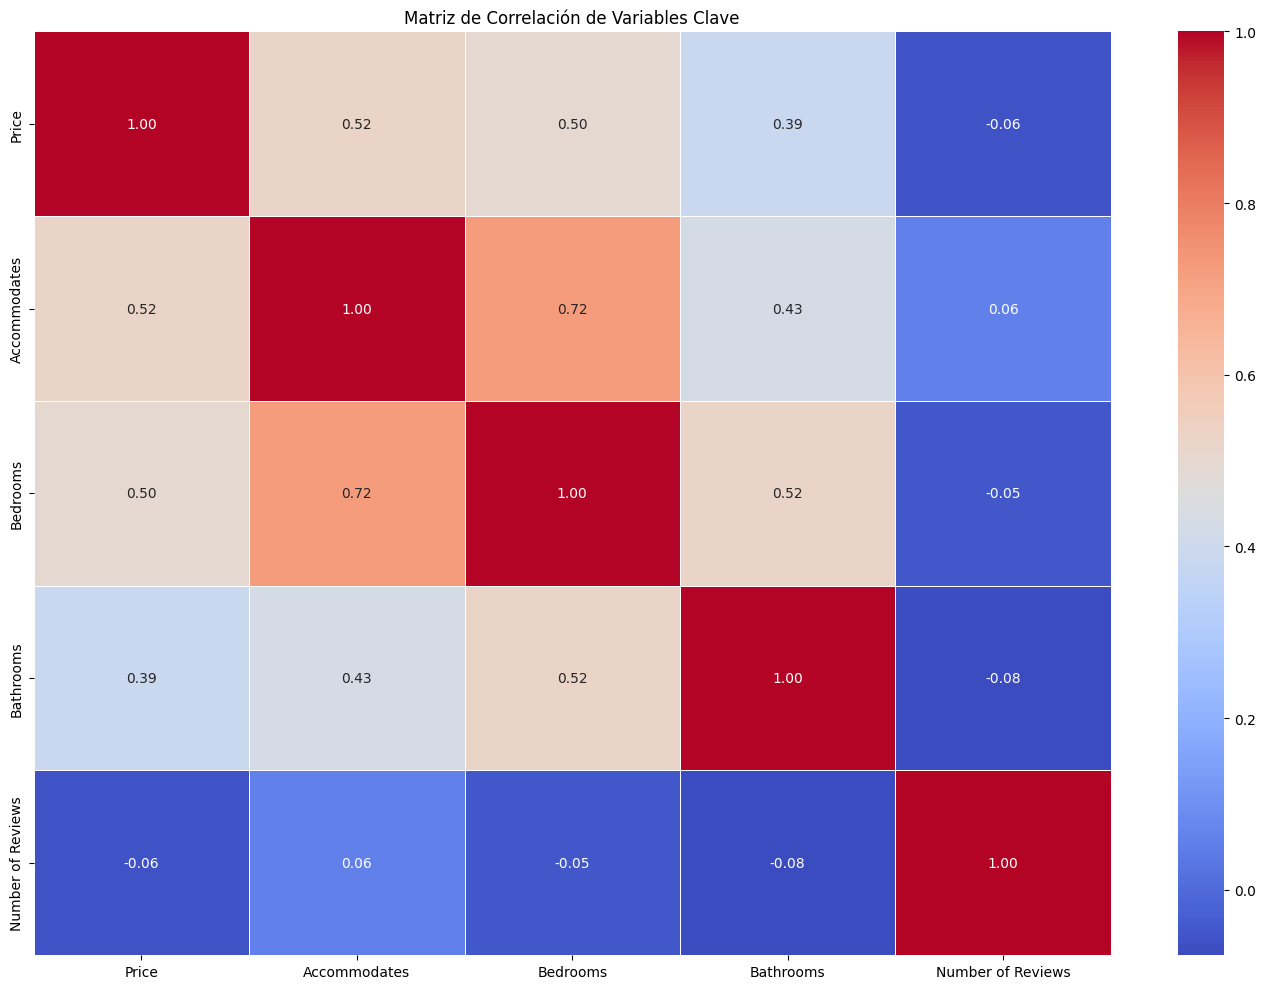

In [13]:
# Análisis de relaciones principales con el precio
key_features = ['Price', 'Accommodates', 'Bedrooms', 'Bathrooms', 'Number of Reviews']
key_df = df_raw[key_features].dropna()

plt.figure(figsize=(14, 10))
sns.heatmap(key_df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Matriz de Correlación de Variables Clave')
plt.tight_layout()
plt.show()

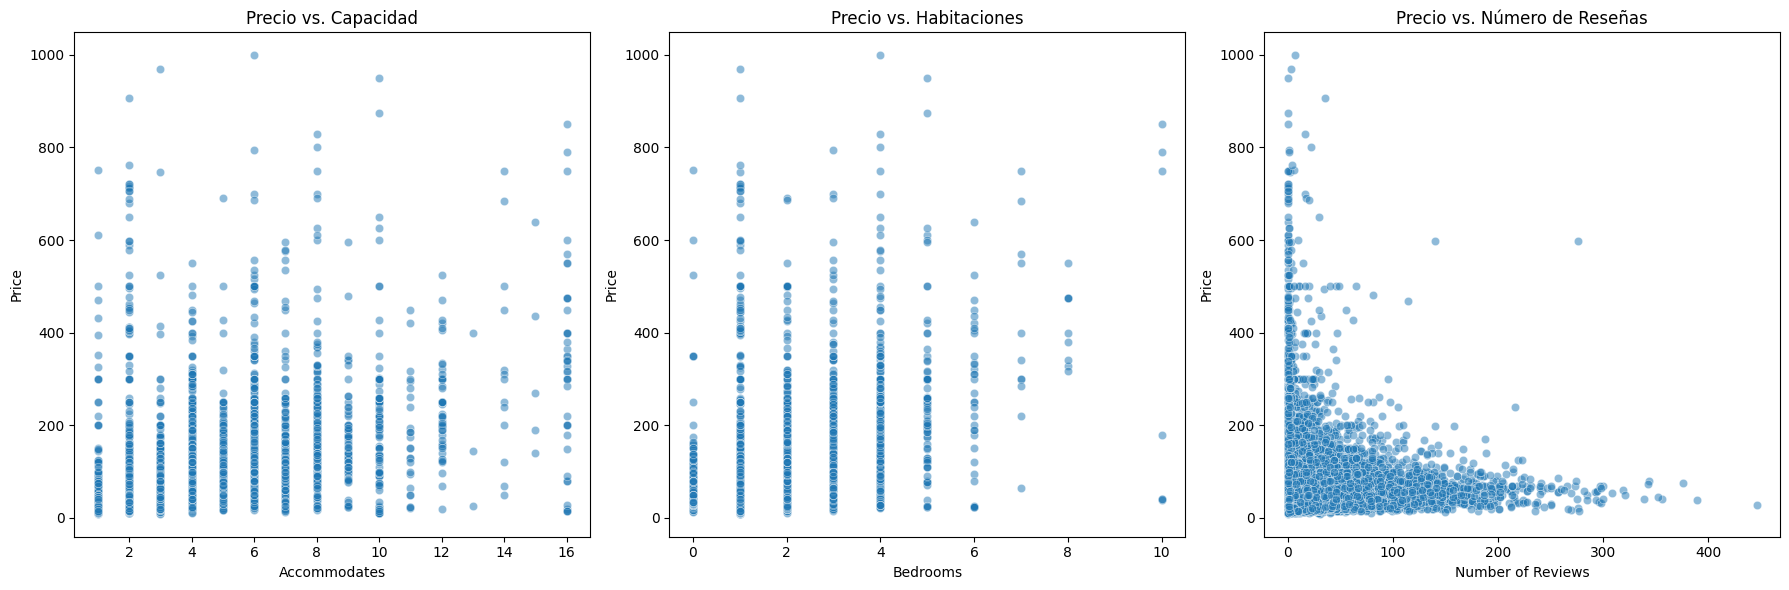

In [14]:
# Muestro algunas relaciones importantes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(x='Accommodates', y='Price', data=key_df, alpha=0.5, ax=axes[0])
axes[0].set_title('Precio vs. Capacidad')

sns.scatterplot(x='Bedrooms', y='Price', data=key_df, alpha=0.5, ax=axes[1])
axes[1].set_title('Precio vs. Habitaciones')

sns.scatterplot(x='Number of Reviews', y='Price', data=key_df, alpha=0.5, ax=axes[2])
axes[2].set_title('Precio vs. Número de Reseñas')

plt.tight_layout()
plt.show()


INICIANDO PROCESO DE LIMPIEZA

In [15]:
# Creo un único DataFrame de trabajo, conservando el original
df_clean = df_raw.copy()

# Identifico columnas a eliminar por alto % de valores faltantes (>50%)
high_missing_cols = missing_df[missing_df['missing_percent'] > 50].index.tolist()
print(f"Identificadas {len(high_missing_cols)} columnas con >50% valores faltantes")

# Elimino identificadores y URLs que no son útiles para la predicción
id_url_cols = [
    'ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Thumbnail Url', 
    'Medium Url', 'Picture Url', 'XL Picture Url', 'Host URL', 
    'Host Thumbnail Url', 'Host Picture Url', 'Calendar last Scraped'
]
print(f"Identificadas {len(id_url_cols)} columnas de identificadores/URLs para eliminar")

# Elimino columnas con texto libre extenso que requeriría NLP
text_cols = [
    'Description', 'Neighborhood Overview', 'Notes', 'Transit', 
    'Access', 'Interaction', 'House Rules', 'Host About', 'Experiences Offered',
    'Space', 'Summary'
]
print(f"Identificadas {len(text_cols)} columnas de texto libre extenso para eliminar")

Identificadas 9 columnas con >50% valores faltantes
Identificadas 12 columnas de identificadores/URLs para eliminar
Identificadas 11 columnas de texto libre extenso para eliminar


In [16]:
# Combino todas las columnas a eliminar
cols_to_drop = high_missing_cols + id_url_cols + text_cols

# Elimino duplicados
duplicates = df_clean.duplicated().sum()
print(f"\nVerificando duplicados: {duplicates} filas duplicadas")

# Elimino las columnas en un solo paso
df_clean = df_clean.drop(columns=[col for col in cols_to_drop if col in df_clean.columns])
print(f"DataFrame después de limpieza inicial: {df_clean.shape[0]:,} filas × {df_clean.shape[1]:,} columnas")

# Muestro cómo quedó el DataFrame después de la limpieza inicial
print("\nMuestra del DataFrame después de la limpieza inicial:")
display(df_clean.head())


Verificando duplicados: 0 filas duplicadas
DataFrame después de limpieza inicial: 14,780 filas × 58 columnas

Muestra del DataFrame después de la limpieza inicial:


,Name,Host ID,Host Name,Host Since,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,...,Review Scores Cleanliness,Review Scores Checkin,Review Scores Communication,Review Scores Location,Review Scores Value,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,The Loft-Full Bath-Deck w/View,58386783,John,2016-02-11,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,NaN,1.0,1.0,...,10.0,10.0,10.0,10.0,10.0,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,"Claris I, Friendly Rentals",102947901,Claudia,2016-11-08,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,...,10.0,10.0,10.0,8.0,10.0,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,"Style Terrace Red, Friendly Rentals",102947901,Claudia,2016-11-08,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,...,NaN,NaN,NaN,NaN,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,Picasso Suite 1.4 Paseo de Gracia,131794,Damien,2010-05-25,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,...,9.0,10.0,10.0,10.0,9.0,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,Smart City Centre Apartment II,54310958,Javier,2016-01-12,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


In [17]:
# Verifico los tipos de datos después de la limpieza inicial
print("\nDistribución de tipos de datos después de la limpieza inicial:")
type_counts = df_clean.dtypes.value_counts()
print(type_counts)


Distribución de tipos de datos después de la limpieza inicial:
object     28
float64    19
int64      11
dtype: int64


In [18]:
# Análisis de valores faltantes restantes
missing_after = df_clean.isnull().sum()
missing_pct_after = (missing_after / len(df_clean) * 100).round(2)
missing_df_after = pd.DataFrame({
    'conteo': missing_after,
    'porcentaje': missing_pct_after
}).sort_values('porcentaje', ascending=False)

print("\nValores faltantes después de la limpieza inicial (top 10):")
display(missing_df_after[missing_df_after['conteo'] > 0].head(10))


Valores faltantes después de la limpieza inicial (top 10):


,conteo,porcentaje
Cleaning Fee,6093,41.22
Neighbourhood,5229,35.38
Host Neighbourhood,3876,26.22
Review Scores Location,3340,22.60
Review Scores Value,3341,22.60
Review Scores Checkin,3337,22.58
Review Scores Accuracy,3326,22.50
Review Scores Cleanliness,3320,22.46
Review Scores Communication,3320,22.46
Review Scores Rating,3304,22.35


TRANSFORMACIÓN DE FECHAS

In [19]:
# Convierto columnas de fecha a datetime
date_cols = ['Host Since', 'First Review', 'Last Review']
for col in date_cols:
    if col in df_clean.columns:
        df_clean[col] = pd.to_datetime(df_clean[col], errors='coerce')

In [20]:
# Verifico la conversión
print("Muestra de las columnas de fecha convertidas:")
display(df_clean[date_cols].head())

# Calculo la fecha de referencia (la más reciente del dataset)
fecha_referencia = df_clean[date_cols].max().max()
print(f"Fecha de referencia para cálculos: {fecha_referencia}")

# Creo variables de antigüedad en un solo paso
df_clean['host_age_years'] = (fecha_referencia - df_clean['Host Since']).dt.days / 365.25
df_clean['days_since_first_review'] = (fecha_referencia - df_clean['First Review']).dt.days
df_clean['days_since_last_review'] = (fecha_referencia - df_clean['Last Review']).dt.days
df_clean['review_gap_years'] = (df_clean['days_since_first_review'] - df_clean['days_since_last_review']) / 365.25

print("\nMuestra de las nuevas variables temporales creadas:")
display(df_clean[['host_age_years', 'days_since_first_review', 
                  'days_since_last_review', 'review_gap_years']].head())

Muestra de las columnas de fecha convertidas:


,Host Since,First Review,Last Review
0,2016-02-11,2016-03-13,2017-02-26
1,2016-11-08,2017-03-05,2017-03-05
2,2016-11-08,NaT,NaT
3,2010-05-25,2016-04-17,2017-03-02
4,2016-01-12,NaT,NaT


Fecha de referencia para cálculos: 2017-06-13 00:00:00

Muestra de las nuevas variables temporales creadas:


,host_age_years,days_since_first_review,days_since_last_review,review_gap_years
0,1.336071,457.0,107.0,0.958248
1,0.594114,100.0,100.0,0.000000
2,0.594114,NaN,NaN,NaN
3,7.052704,422.0,103.0,0.873374
4,1.418207,NaN,NaN,NaN


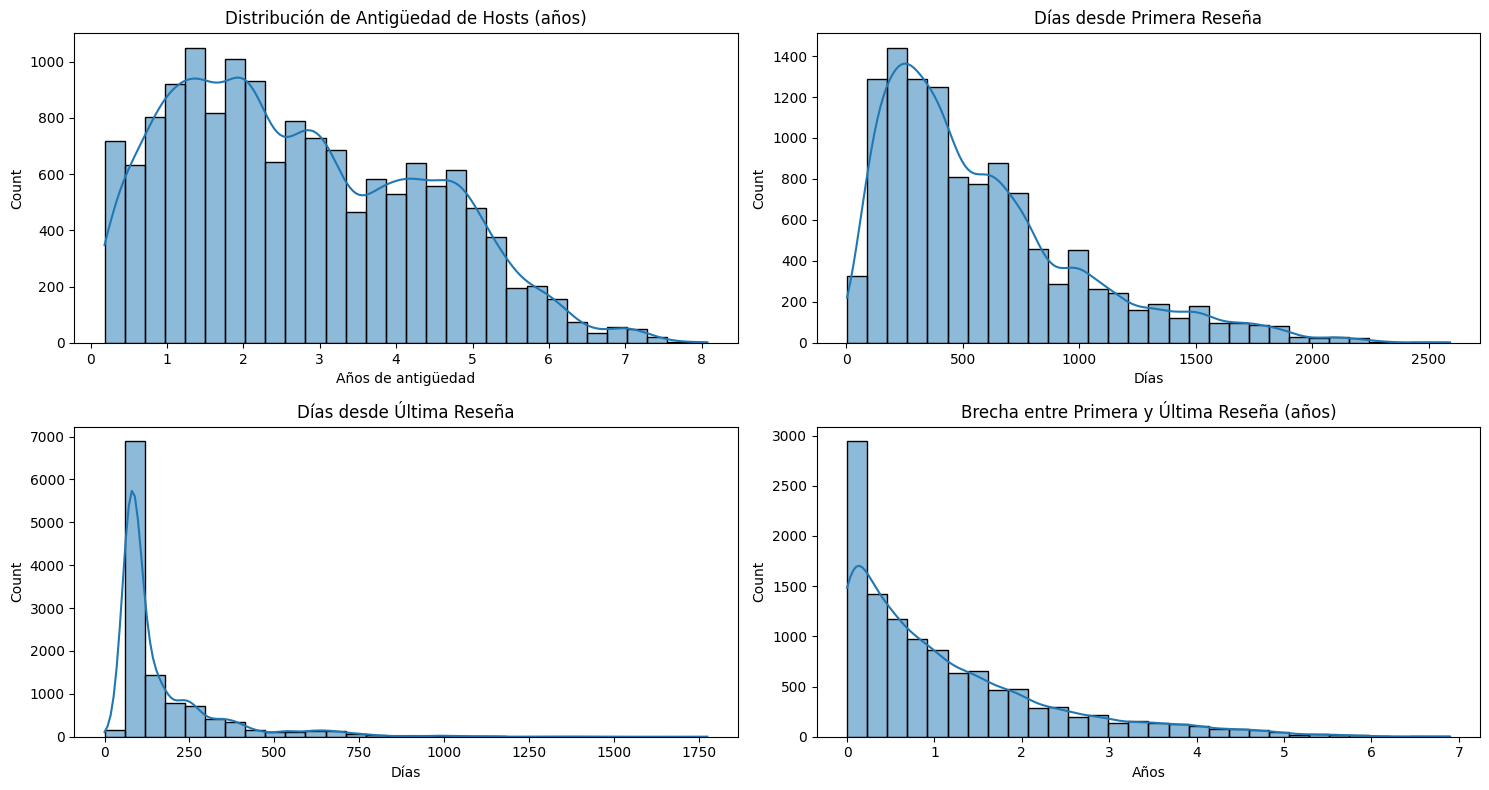

In [21]:
# Visualización: Distribución de la antigüedad de los hosts
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
sns.histplot(df_clean['host_age_years'].dropna(), bins=30, kde=True)
plt.title('Distribución de Antigüedad de Hosts (años)')
plt.xlabel('Años de antigüedad')

plt.subplot(2, 2, 2)
sns.histplot(df_clean['days_since_first_review'].dropna(), bins=30, kde=True)
plt.title('Días desde Primera Reseña')
plt.xlabel('Días')

plt.subplot(2, 2, 3)
sns.histplot(df_clean['days_since_last_review'].dropna(), bins=30, kde=True)
plt.title('Días desde Última Reseña')
plt.xlabel('Días')

plt.subplot(2, 2, 4)
sns.histplot(df_clean['review_gap_years'].dropna(), bins=30, kde=True)
plt.title('Brecha entre Primera y Última Reseña (años)')
plt.xlabel('Años')

plt.tight_layout()
plt.show()

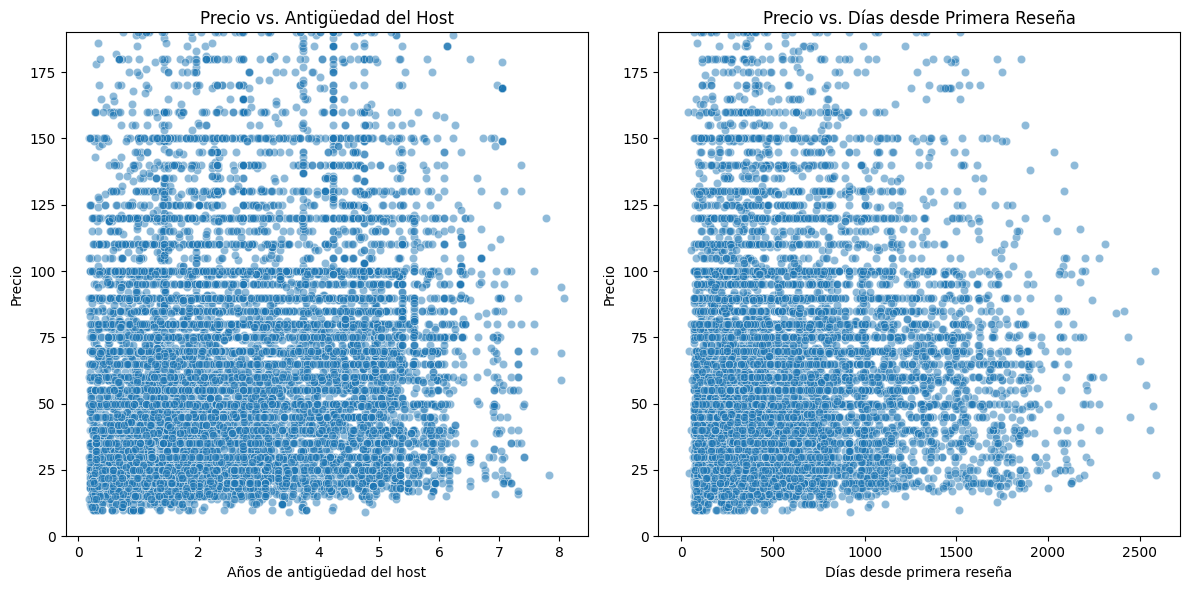


Columnas de fecha originales eliminadas: ['Host Since', 'First Review', 'Last Review']


In [22]:
# Analizo relación entre antigüedad y precio
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(x='host_age_years', y='Price', data=df_clean, alpha=0.5)
plt.title('Precio vs. Antigüedad del Host')
plt.xlabel('Años de antigüedad del host')
plt.ylabel('Precio')
plt.ylim(0, df_clean['Price'].quantile(0.95))

plt.subplot(1, 2, 2)
sns.scatterplot(x='days_since_first_review', y='Price', data=df_clean, alpha=0.5)
plt.title('Precio vs. Días desde Primera Reseña')
plt.xlabel('Días desde primera reseña')
plt.ylabel('Precio')
plt.ylim(0, df_clean['Price'].quantile(0.95))

plt.tight_layout()
plt.show()

# Elimino columnas originales de fecha
df_clean.drop(columns=date_cols, inplace=True)
print(f"\nColumnas de fecha originales eliminadas: {date_cols}")

EXTRACCIÓN DE INFORMACIÓN DE LISTAS

In [23]:
# Muestro ejemplos de listas en texto para entender su estructura
print("Ejemplos de listas en las columnas de texto:")
print("\nEjemplo de 'Amenities':")
print(df_clean['Amenities'].iloc[0])
print("\nEjemplo de 'Host Verifications':")
print(df_clean['Host Verifications'].iloc[0])

Ejemplos de listas en las columnas de texto:

Ejemplo de 'Amenities':
TV,Cable TV,Internet,Wireless Internet,Air conditioning,Pool,Free parking on premises,Heating,Family/kid friendly,Smoke detector,Carbon monoxide detector,Fire extinguisher,Essentials,Shampoo,Lock on bedroom door,24-hour check-in,Hangers,Hair dryer,Iron,Laptop friendly workspace,Self Check-In,Doorman Entry,Private entrance

Ejemplo de 'Host Verifications':
email,phone,reviews,kba


In [24]:
# Aseguro que las columnas relevantes sean string
df_clean['Amenities'] = df_clean['Amenities'].astype(str)
df_clean['Host Verifications'] = df_clean['Host Verifications'].astype(str)

# Creo variables de conteo
df_clean['n_amenities'] = df_clean['Amenities'].apply(lambda x: len(x.split(',')) if x.strip() != '' else 0)
df_clean['n_verifications'] = df_clean['Host Verifications'].apply(lambda x: len(x.split(',')) if x.strip() != '' else 0)

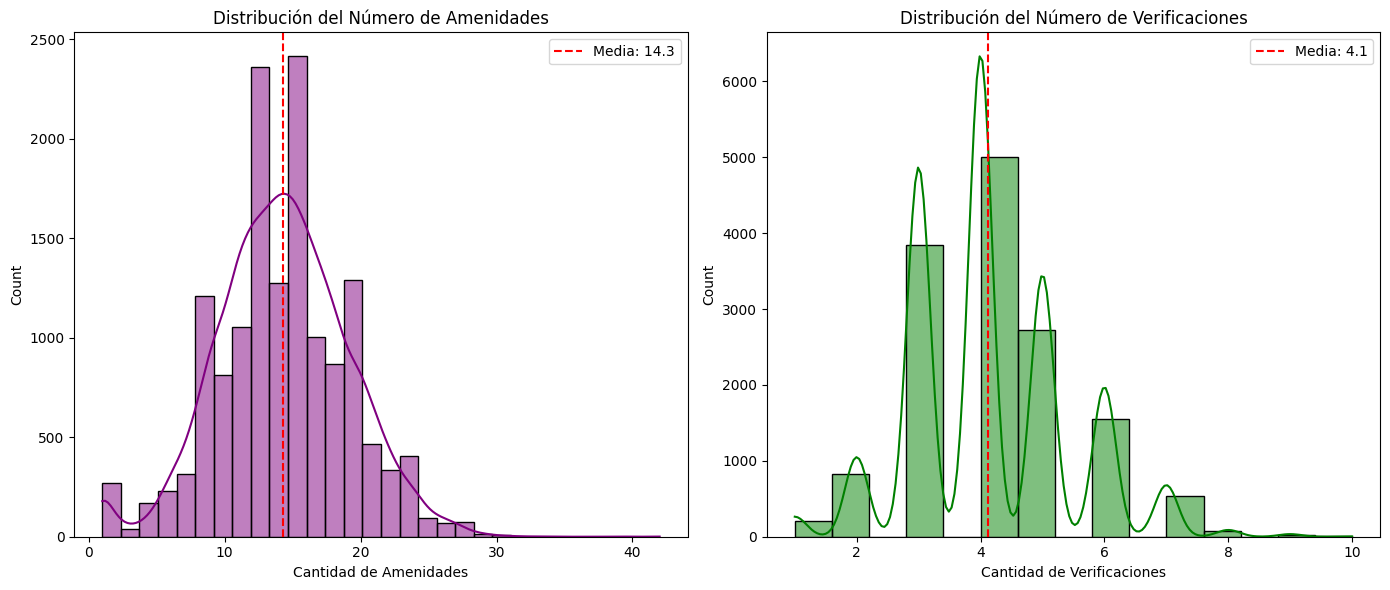

In [25]:
# Visualización: Distribución de conteos
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(df_clean['n_amenities'], bins=30, kde=True, color='purple')
plt.title('Distribución del Número de Amenidades')
plt.xlabel('Cantidad de Amenidades')
plt.axvline(df_clean['n_amenities'].mean(), color='red', linestyle='--', 
           label=f'Media: {df_clean["n_amenities"].mean():.1f}')
plt.legend()

plt.subplot(1, 2, 2)
sns.histplot(df_clean['n_verifications'], bins=15, kde=True, color='green')
plt.title('Distribución del Número de Verificaciones')
plt.xlabel('Cantidad de Verificaciones')
plt.axvline(df_clean['n_verifications'].mean(), color='red', linestyle='--',
           label=f'Media: {df_clean["n_verifications"].mean():.1f}')
plt.legend()

plt.tight_layout()
plt.show()

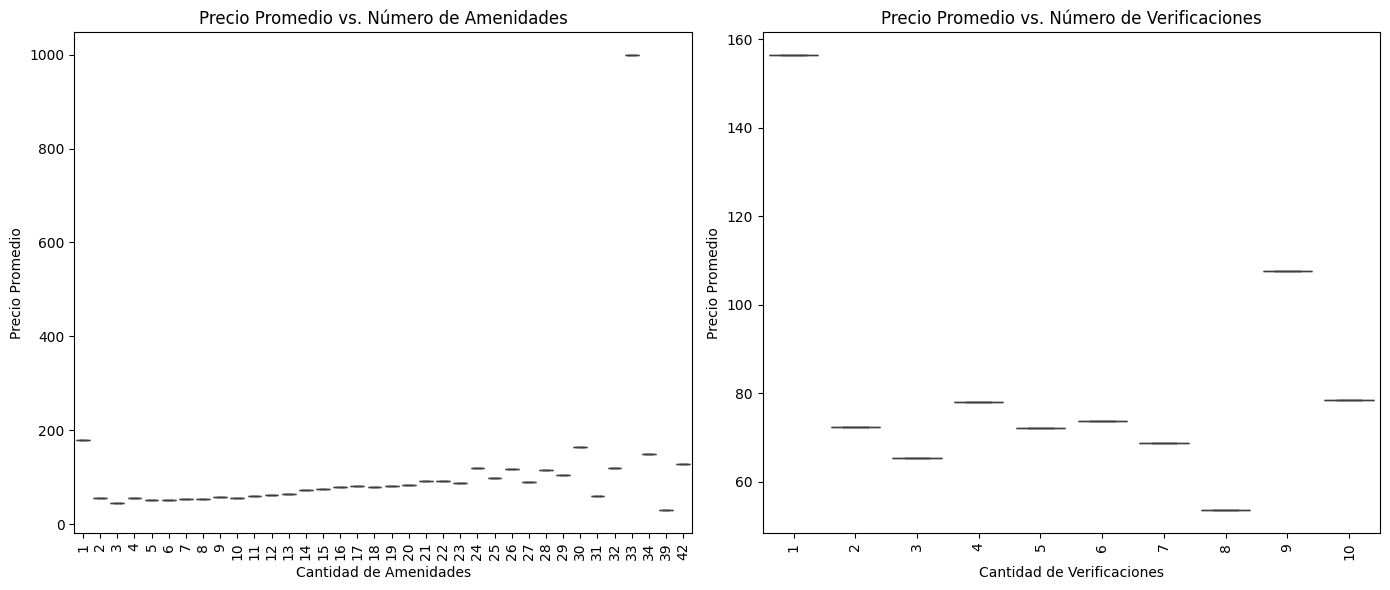


Estadísticas de las nuevas variables de conteo:
        n_amenities  n_verifications
count  14780.000000     14780.000000
mean      14.280920         4.118539
std        4.844211         1.286549
min        1.000000         1.000000
25%       11.000000         3.000000
50%       14.000000         4.000000
75%       17.000000         5.000000
max       42.000000        10.000000

Columnas originales de texto eliminadas después de extracción de características

Estructura del DataFrame después de procesar listas: (14780, 59)


,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Street,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,NaN,1.0,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23,4
1,"Claris I, Friendly Rentals",102947901,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,"Barcelona, Barcelona 08010, Spain",...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7,4
2,"Style Terrace Red, Friendly Rentals",102947901,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,NaN,162.0,162.0,"Barcelona, Barcelona 08008, Spain",...,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,NaN,NaN,NaN,7,4
3,Picasso Suite 1.4 Paseo de Gracia,131794,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,"Barcelona, Barcelona 08009, Spain",...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24,7
4,Smart City Centre Apartment II,54310958,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",...,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,NaN,NaN,NaN,12,4


In [26]:
# Analizo relación entre estas características y el precio
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='n_amenities', y='Price', data=df_clean.groupby('n_amenities')['Price'].mean().reset_index())
plt.title('Precio Promedio vs. Número de Amenidades')
plt.xlabel('Cantidad de Amenidades')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
sns.boxplot(x='n_verifications', y='Price', data=df_clean.groupby('n_verifications')['Price'].mean().reset_index())
plt.title('Precio Promedio vs. Número de Verificaciones')
plt.xlabel('Cantidad de Verificaciones')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

# Muestro estadísticas de las nuevas variables
print("\nEstadísticas de las nuevas variables de conteo:")
print(df_clean[['n_amenities', 'n_verifications']].describe())

# Elimino las columnas originales
df_clean.drop(columns=['Amenities', 'Host Verifications'], inplace=True)
print("\nColumnas originales de texto eliminadas después de extracción de características")

# Muestro la estructura actualizada del DataFrame
print(f"\nEstructura del DataFrame después de procesar listas: {df_clean.shape}")
display(df_clean.head())

IMPUTACIÓN DE VALORES FALTANTES

In [27]:
# Análisis inicial de valores faltantes antes de imputación
missing_before = df_clean.isnull().sum()
missing_pct_before = (missing_before / len(df_clean) * 100).round(2)

print("Valores faltantes antes de imputación:")
missing_summary = pd.DataFrame({
    'Conteo': missing_before,
    'Porcentaje': missing_pct_before
}).sort_values('Conteo', ascending=False)
display(missing_summary[missing_summary['Conteo'] > 0].head(10))

Valores faltantes antes de imputación:


,Conteo,Porcentaje
Cleaning Fee,6093,41.22
Neighbourhood,5229,35.38
Host Neighbourhood,3876,26.22
Review Scores Value,3341,22.60
Review Scores Location,3340,22.60
Review Scores Checkin,3337,22.58
Review Scores Accuracy,3326,22.50
Review Scores Communication,3320,22.46
Review Scores Cleanliness,3320,22.46
Review Scores Rating,3304,22.35


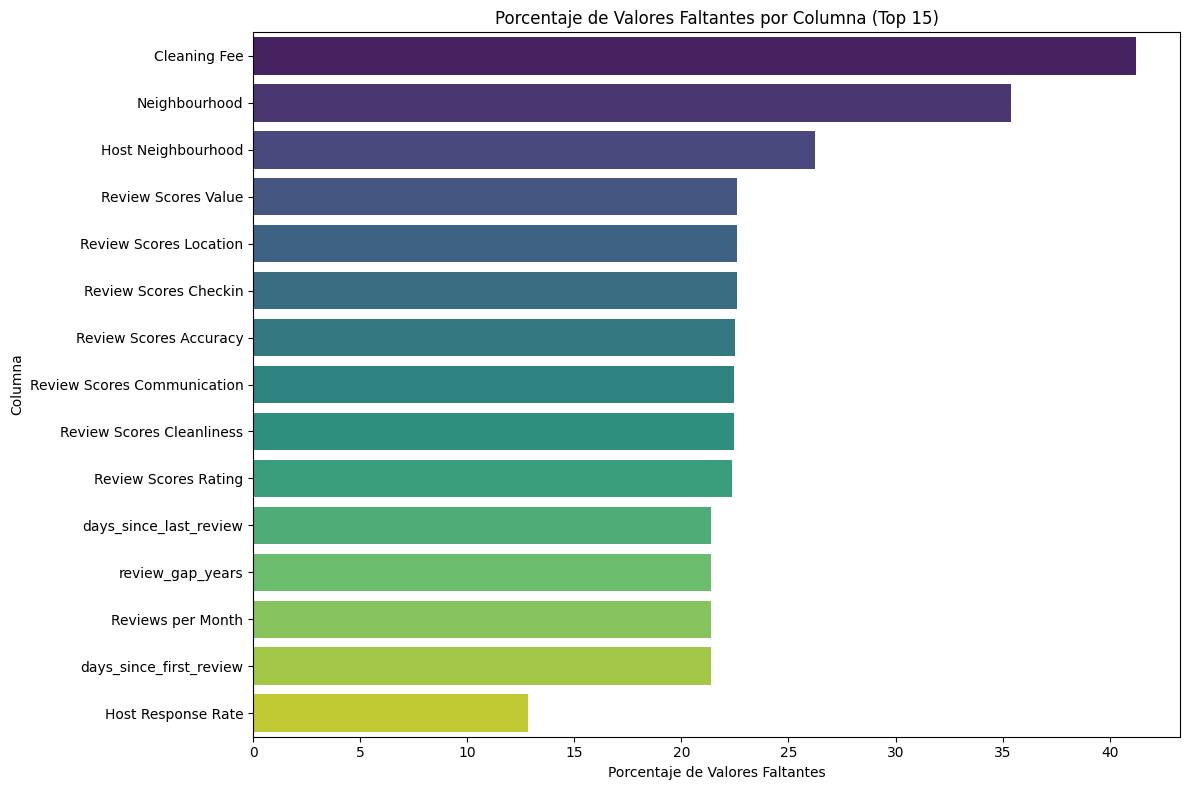

In [28]:
# Visualización de valores faltantes (top 15 columnas)
plt.figure(figsize=(12, 8))
cols_with_missing = missing_summary[missing_summary['Conteo'] > 0].index[:15]
missing_data = missing_summary.loc[cols_with_missing, 'Porcentaje']

# Crear un DataFrame explícito para evitar el warning
missing_df = pd.DataFrame({
    'Columna': cols_with_missing,
    'Porcentaje': missing_data.values
})

sns.barplot(data=missing_df, x='Porcentaje', y='Columna', hue='Columna', palette='viridis', legend=False, dodge=False)
plt.title('Porcentaje de Valores Faltantes por Columna (Top 15)')
plt.xlabel('Porcentaje de Valores Faltantes')
plt.ylabel('Columna')
plt.tight_layout()
plt.show()

In [29]:
# Guardar conteo antes de imputar
missing_before = df_clean.isnull().sum()
missing_pct_before = (missing_before / len(df_clean) * 100).round(2)

In [30]:
# Verificación y asignación segura de columnas por tipo
num_cols = [col for col in df_clean.select_dtypes(include=['float64', 'int64']).columns]

date_cols = ['Last Review', 'First Review', 'Host Since']
date_cols = [col for col in date_cols if col in df_clean.columns]

url_cols = [
    'XL Picture Url', 'Medium Url', 'Thumbnail Url',
    'Picture Url', 'Host Thumbnail Url', 'Host Picture Url'
]
url_cols = [col for col in url_cols if col in df_clean.columns]

rate_cols = ['Host Response Rate', 'Host Response Time']
rate_cols = [col for col in rate_cols if col in df_clean.columns]

text_cols = [
    'Neighbourhood', 'Neighbourhood Group Cleansed', 'Summary', 'Zipcode', 'Amenities',
    'State', 'Market', 'Host Location', 'City', 'Name', 'Description',
    'Features', 'Host Verifications', 'Host Name', 'Host Neighbourhood',
    'Street', 'Geolocation'
]
text_cols = [col for col in text_cols if col in df_clean.columns]

zero_cols = ['Cleaning Fee']
zero_cols = [col for col in zero_cols if col in df_clean.columns]

In [31]:
# Crear los imputadores
imp_mediana = SimpleImputer(strategy='median')
imp_missing = SimpleImputer(strategy='constant', fill_value='missing')
imp_no_image = SimpleImputer(strategy='constant', fill_value='no_image')
imp_unknown = SimpleImputer(strategy='constant', fill_value='unknown')
imp_empty = SimpleImputer(strategy='constant', fill_value='')
imp_zero = SimpleImputer(strategy='constant', fill_value=0)

In [32]:
# Aplicar imputación por tipo
if num_cols:
    df_clean[num_cols] = imp_mediana.fit_transform(df_clean[num_cols])

if date_cols:
    df_clean[date_cols] = df_clean[date_cols].astype(str)
    df_clean[date_cols] = imp_missing.fit_transform(df_clean[date_cols])

if url_cols:
    df_clean[url_cols] = imp_no_image.fit_transform(df_clean[url_cols])

if rate_cols:
    df_clean[rate_cols] = imp_unknown.fit_transform(df_clean[rate_cols])

if text_cols:
    df_clean[text_cols] = imp_empty.fit_transform(df_clean[text_cols])

if zero_cols:
    df_clean[zero_cols] = imp_zero.fit_transform(df_clean[zero_cols])

In [33]:
if 'Country' in df_clean.columns:
    most_common_country = df_clean['Country'].mode()[0]
    df_clean['Country'] = df_clean['Country'].fillna(most_common_country)
    print(f"Columna 'Country' imputada con valor más frecuente: {most_common_country}")

Columna 'Country' imputada con valor más frecuente: Spain


In [34]:
# Verificación después de la imputación
missing_after = df_clean.isnull().sum()
missing_pct_after = (missing_after / len(df_clean) * 100).round(2)

if missing_after.sum() > 0:
    print("\nValores faltantes restantes después de imputación:")
    missing_after_df = pd.DataFrame({
        'Conteo': missing_after,
        'Porcentaje': missing_pct_after
    }).sort_values('Conteo', ascending=False)
    display(missing_after_df[missing_after_df['Conteo'] > 0])
else:
    print("\nNo quedan valores faltantes en el dataset.")


No quedan valores faltantes en el dataset.


In [35]:
# Mostrar muestra del DataFrame final
print("\nMuestra del DataFrame después de imputación:")
display(df_clean.head())


Muestra del DataFrame después de imputación:


,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Street,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783.0,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23.0,4.0
1,"Claris I, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,162.0,"Barcelona, Barcelona 08010, Spain",...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7.0,4.0
2,"Style Terrace Red, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,162.0,"Barcelona, Barcelona 08008, Spain",...,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,454.0,97.0,0.752909,7.0,4.0
3,Picasso Suite 1.4 Paseo de Gracia,131794.0,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,"Barcelona, Barcelona 08009, Spain",...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24.0,7.0
4,Smart City Centre Apartment II,54310958.0,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",...,92.0,1.20,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,454.0,97.0,0.752909,12.0,4.0


 Heatmap de valores faltantes después de la imputación


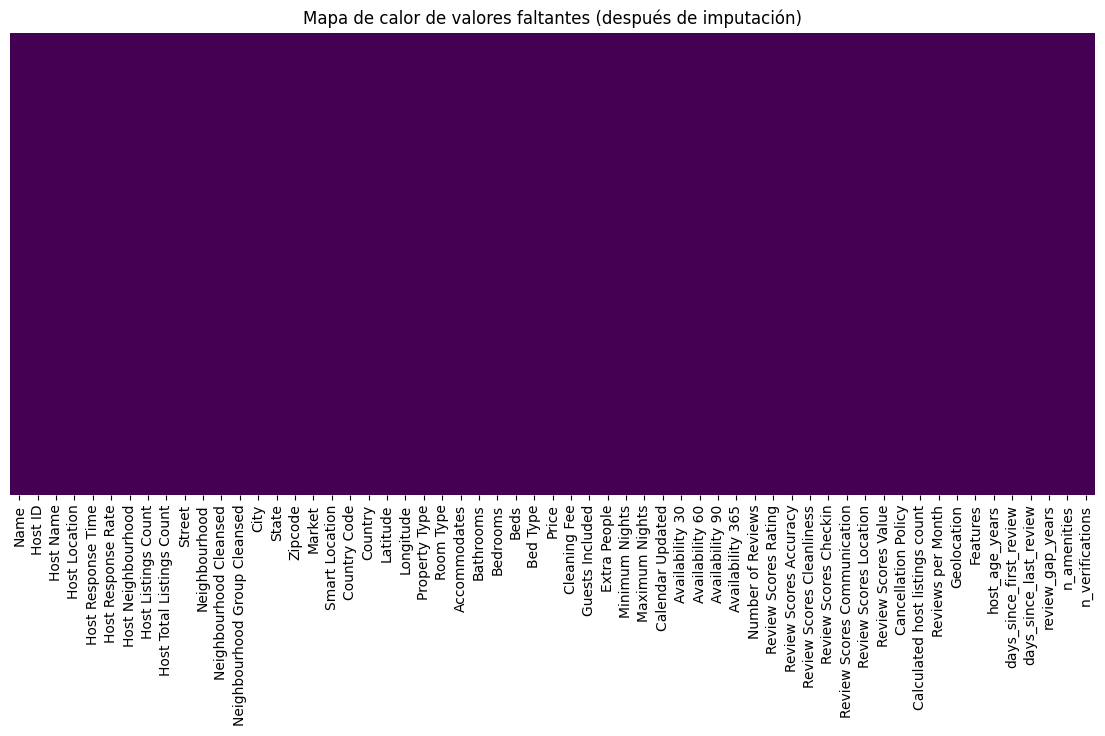

In [36]:
plt.figure(figsize=(14, 6))
sns.heatmap(df_clean.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Mapa de calor de valores faltantes (después de imputación)')
plt.show()

# Detección y manejo de outliers
A continuación se definen tres métodos de detección (Z-score, IQR e IsolationForest),
se comparan sus conteos y finalmente se filtran los outliers del DataFrame `df_clean`
usando el método IQR (recomendado por su robustez)

In [37]:
def detect_zscore(df, cols, thresh=3.0):
    mask = np.abs(zscore(df[cols], nan_policy='omit')) > thresh
    return pd.DataFrame(mask, columns=cols).any(axis=1)

def detect_iqr(df, cols, k=1.5):
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    mask = ((df[cols] < lower) | (df[cols] > upper))
    return mask.any(axis=1)

def detect_iforest(df, cols, contamination=0.01, random_state=SEED):
    iso = IsolationForest(contamination=contamination,
                          random_state=random_state)
    X = df[cols].fillna(df[cols].median())
    preds = iso.fit_predict(X)
    return preds == -1

# Aplicando los métodos a df_clean

numeric_cols = df_clean.select_dtypes(include='number').columns.tolist()

out_z   = detect_zscore(df_clean, numeric_cols, thresh=3.0)
out_iqr = detect_iqr(df_clean, numeric_cols, k=1.5)
out_if  = detect_iforest(df_clean, numeric_cols, contamination=0.01)

summary = pd.DataFrame({
    'Z-score (>3σ)'     : out_z.sum(),
    'IQR (1.5·IQR)'      : out_iqr.sum(),
    'IsolationForest(1%)': out_if.sum()
}, index=['# outliers']).T

print(summary)

df_no_outliers = df_clean.loc[~out_iqr].reset_index(drop=True)
print(f"\nDimensiones antes: {df_clean.shape}")
print(f"Dimensiones después: {df_no_outliers.shape}")

                     # outliers
Z-score (>3σ)              3547
IQR (1.5·IQR)             11198
IsolationForest(1%)         148

Dimensiones antes: (14780, 59)
Dimensiones después: (3582, 59)


- IQR es demasiado agresivo (quita casi 3 de cada 4 filas).
- Z-score elimina casi el 20%: útil si las variables son aprox. normales y quieres limpiar valores extremos univariados.
- IsolationForest está alineado con tu parámetro contamination=0.01 (1%); captura patrones multivariados sin desbaratar tu dataset.


In [38]:
# Aplicación de IsolationForest (1% cont.)
out_if = detect_iforest(df_clean, numeric_cols, contamination=0.01)

# Filtrar dataset
df_filtered = df_clean.loc[~out_if].reset_index(drop=True)

# Mostrar tamaños
print(f"Filas originales: {df_clean.shape[0]}")
print(f"Filas tras IForest: {df_filtered.shape[0]}")

# Inspeccionar el dataframe resultante
display(df_filtered.head())       # Primeras 5 filas
display(df_filtered.info())       # Estructura y tipos
display(df_filtered.describe())   # Estadísticas resumen

Filas originales: 14780
Filas tras IForest: 14632


,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Host Total Listings Count,Street,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783.0,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23.0,4.0
1,"Claris I, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,162.0,"Barcelona, Barcelona 08010, Spain",...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7.0,4.0
2,"Style Terrace Red, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,162.0,"Barcelona, Barcelona 08008, Spain",...,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,454.0,97.0,0.752909,7.0,4.0
3,Picasso Suite 1.4 Paseo de Gracia,131794.0,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,27.0,"Barcelona, Barcelona 08009, Spain",...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24.0,7.0
4,Smart City Centre Apartment II,54310958.0,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",...,92.0,1.20,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,454.0,97.0,0.752909,12.0,4.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14632 entries, 0 to 14631
Data columns (total 59 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Name                            14632 non-null  object 
 1   Host ID                         14632 non-null  float64
 2   Host Name                       14632 non-null  object 
 3   Host Location                   14632 non-null  object 
 4   Host Response Time              14632 non-null  object 
 5   Host Response Rate              14632 non-null  object 
 6   Host Neighbourhood              14632 non-null  object 
 7   Host Listings Count             14632 non-null  float64
 8   Host Total Listings Count       14632 non-null  float64
 9   Street                          14632 non-null  object 
 10  Neighbourhood                   14632 non-null  object 
 11  Neighbourhood Cleansed          14632 non-null  object 
 12  Neighbourhood Group Cleansed    

None

,Host ID,Host Listings Count,Host Total Listings Count,Latitude,Longitude,Accommodates,Bathrooms,Bedrooms,Beds,Price,...,Review Scores Location,Review Scores Value,Calculated host listings count,Reviews per Month,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
count,1.463200e+04,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,...,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000,14632.000000
mean,3.621536e+07,11.698674,11.698674,40.501453,-3.862065,3.236946,1.267257,1.325519,2.011892,72.514762,...,9.652816,9.195257,8.838846,1.740645,2.727731,552.875068,153.110716,1.046000,14.282873,4.120079
std,3.429482e+07,32.439948,32.439948,4.612971,13.987748,2.025089,0.624639,0.857671,1.538780,69.973607,...,0.667980,0.762258,22.091557,1.679703,1.619561,386.049596,149.366815,1.051290,4.838942,1.290280
min,1.745300e+04,0.000000,0.000000,-37.851182,-123.131344,1.000000,0.000000,0.000000,1.000000,9.000000,...,2.000000,2.000000,1.000000,0.020000,0.183436,4.000000,0.000000,0.000000,1.000000,1.000000
25%,6.902427e+06,1.000000,1.000000,40.409773,-3.707596,2.000000,1.000000,1.000000,1.000000,34.000000,...,9.000000,9.000000,1.000000,0.630000,1.412731,304.000000,79.000000,0.361396,11.000000,3.000000
50%,2.484778e+07,2.000000,2.000000,40.419508,-3.700810,3.000000,1.000000,1.000000,2.000000,55.000000,...,10.000000,9.000000,2.000000,1.200000,2.476386,454.000000,97.000000,0.752909,14.000000,4.000000
75%,5.451022e+07,5.000000,5.000000,40.430915,-3.684605,4.000000,1.000000,2.000000,2.000000,85.000000,...,10.000000,10.000000,5.000000,2.242500,3.989049,671.000000,157.000000,1.349760,17.000000,5.000000
max,1.247534e+08,519.000000,519.000000,55.966912,153.371427,16.000000,8.000000,10.000000,16.000000,999.000000,...,10.000000,10.000000,145.000000,17.210000,8.073922,2591.000000,1774.000000,6.896646,42.000000,10.000000


ANÁLISIS DE COLINEALIDAD

In [39]:
# Selecciono variables numéricas para análisis
numeric_cols = df_filtered.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Analizando colinealidad entre {len(numeric_cols)} variables numéricas")

# Calculo matriz de correlación
corr_matrix = df_filtered[numeric_cols].corr(numeric_only=True)

Analizando colinealidad entre 35 variables numéricas


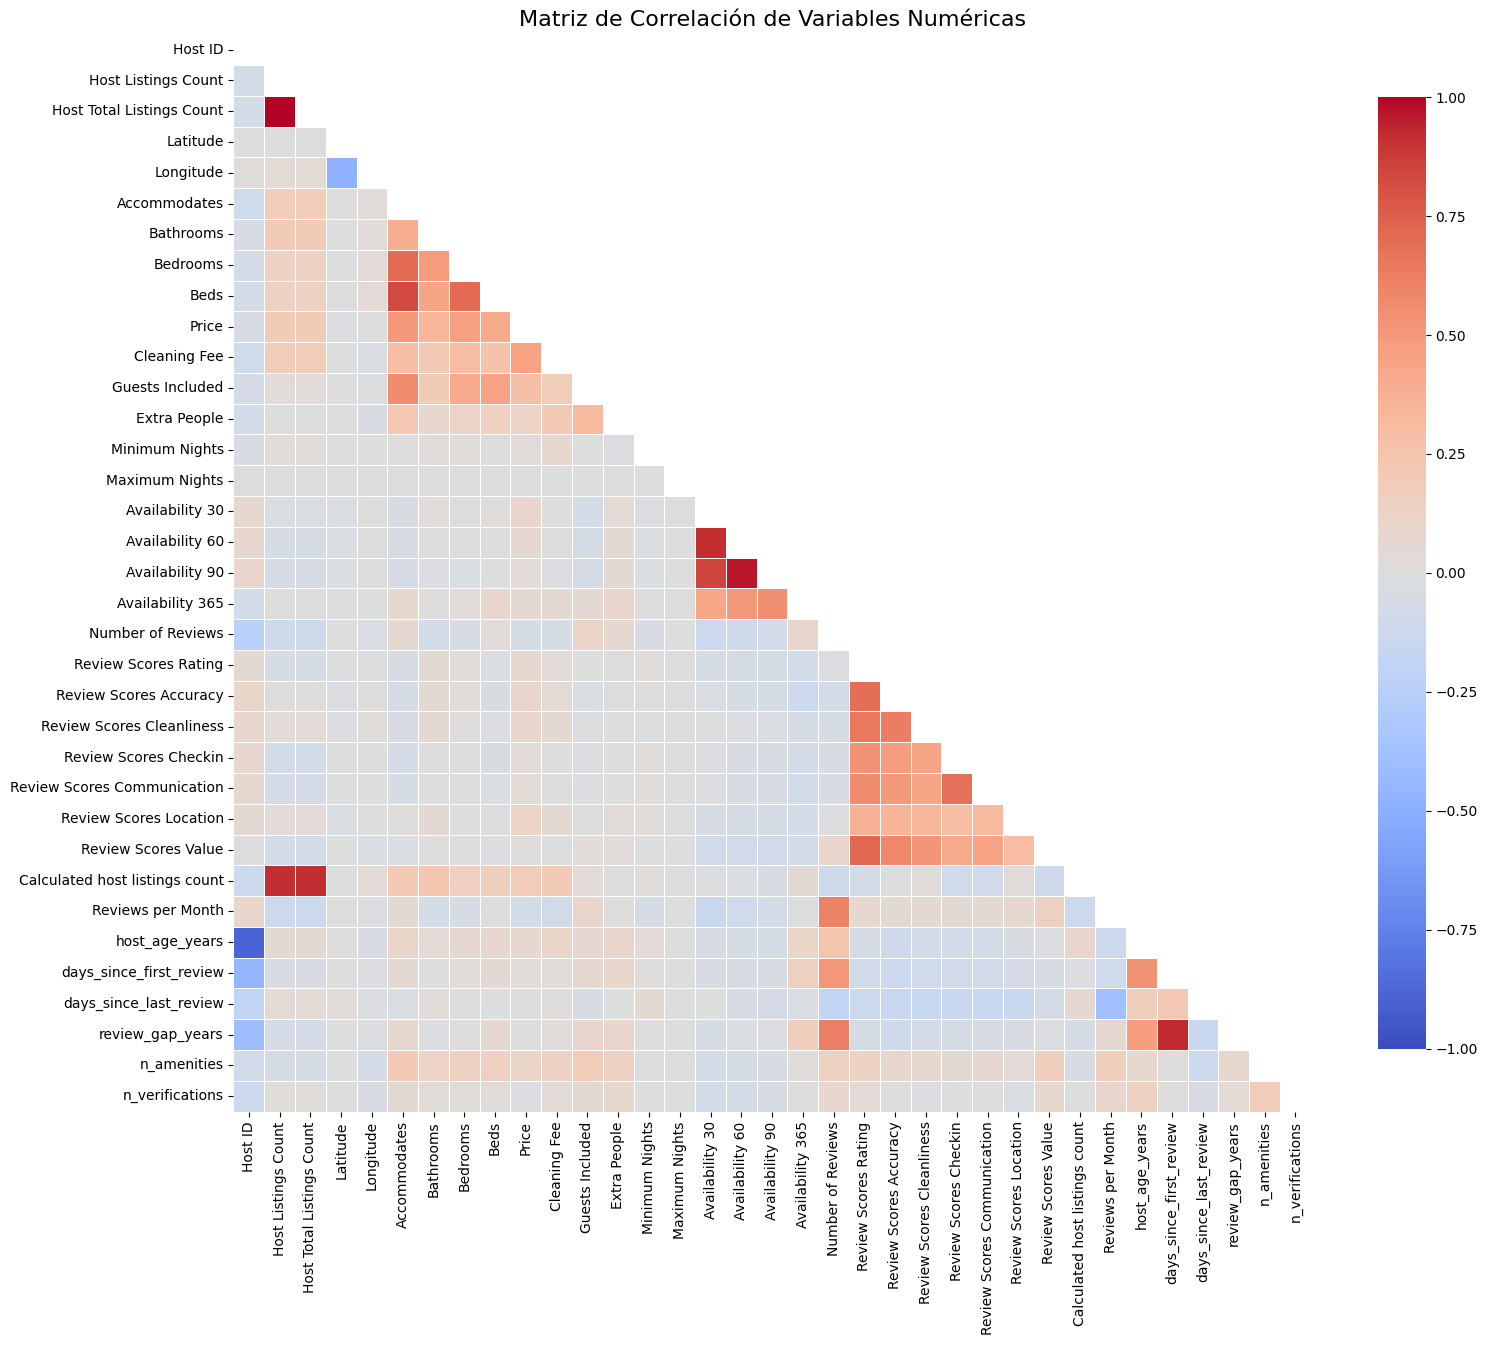

In [40]:
plt.figure(figsize=(16, 14))

# Máscara para ocultar el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Heatmap con estilo mejorado
sns.heatmap(
    corr_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=False,       # Puedes poner True si deseas ver los valores
    center=0,
    linewidths=0.5,
    square=True,
    vmin=-1,
    vmax=1,
    cbar_kws={"shrink": 0.8}  # Opcional: hace más pequeña la barra de color
)

plt.title('Matriz de Correlación de Variables Numéricas', fontsize=16)
plt.tight_layout()
plt.show()


Pares de variables con alta correlación (> 0.8):


,Variable 1,Variable 2,Correlación
0,Host Total Listings Count,Host Listings Count,1.000000
4,Availability 90,Availability 60,0.963538
8,review_gap_years,days_since_first_review,0.927567
2,Availability 60,Availability 30,0.921328
5,Calculated host listings count,Host Listings Count,0.918381
6,Calculated host listings count,Host Total Listings Count,0.918381
7,host_age_years,Host ID,-0.883579
3,Availability 90,Availability 30,0.850059
1,Beds,Accommodates,0.828331


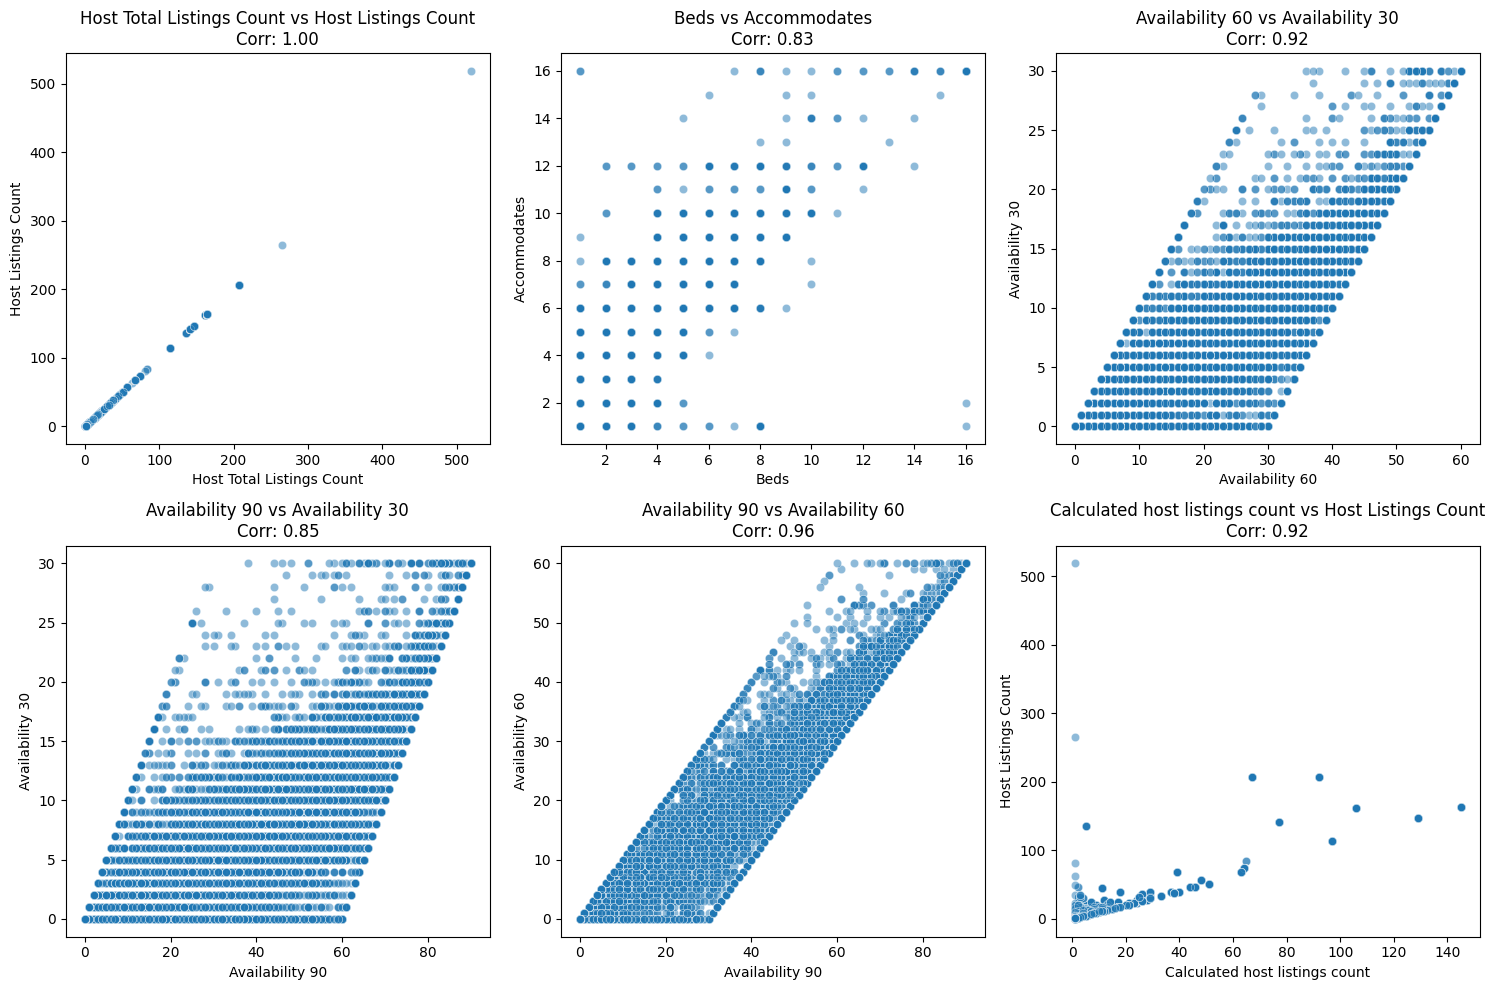

In [41]:
# Visualizo correlaciones altas (solo para análisis)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        corr_value = corr_matrix.iloc[i, j]
        if abs(corr_value) > 0.8:
            high_corr.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_value
            ))

# Paso 2: Mostrar tabla con los pares encontrados
if high_corr:
    high_corr_df = pd.DataFrame(high_corr, columns=['Variable 1', 'Variable 2', 'Correlación'])
    print("\nPares de variables con alta correlación (> 0.8):")
    display(high_corr_df.sort_values(by='Correlación', key=abs, ascending=False))

    # Paso 3: Visualizar los 6 pares más correlacionados como scatterplots
    plt.figure(figsize=(15, 10))
    
    for i, (var1, var2, corr) in enumerate(high_corr[:6], 1):
        # Solo graficamos si ambas variables existen en df_filtered
        if var1 in df_filtered.columns and var2 in df_filtered.columns:
            plt.subplot(2, 3, i)
            sns.scatterplot(x=var1, y=var2, data=df_filtered, alpha=0.5)
            plt.title(f'{var1} vs {var2}\nCorr: {corr:.2f}')
    
    plt.tight_layout()
    plt.show()

In [42]:
# Lista de variables a eliminar por colinealidad fuerte
cols_to_drop_colineal = [
    'Host Total Listings Count',         # Altamente correlacionada con Host Listings Count
    'Availability 30',
    'Availability 60',
    'Availability 90'                    # Las tres correlacionadas con Availability 365
]

# Verifica qué columnas realmente están presentes en df_filtered
existing_colineal = [col for col in cols_to_drop_colineal if col in df_filtered.columns]

# Si hay columnas que eliminar, lo hacemos
if existing_colineal:
    print(f"\nEliminando {len(existing_colineal)} variables colineales: {existing_colineal}")
    df_filtered.drop(columns=existing_colineal, inplace=True)


Eliminando 4 variables colineales: ['Host Total Listings Count', 'Availability 30', 'Availability 60', 'Availability 90']


Durante la exploración encontramos varias relaciones bastante fuertes entre variables del dataset. Por ejemplo, no sorprende ver que a mayor número de camas (Beds), más personas se pueden alojar (Accommodates). La correlación entre estas dos es de 0.84, así que probablemente una de las dos es suficiente para el modelo (nos quedaríamos con la que aporte más valor o sea más interpretable).

También vimos que el número de propiedades que tiene un anfitrión (Calculated host listings count) está fuertemente correlacionado con el conteo oficial de publicaciones (Host Listings Count). Básicamente están diciendo lo mismo, así que tiene sentido dejar solo una para evitar duplicidad.

Otro caso curioso es la relación entre la antigüedad del anfitrión (host_age_years) y el ID del host. Tienen una correlación negativa bastante alta (-0.88), pero esto se explica porque los IDs se asignan secuencialmente, así que los hosts más nuevos tienen IDs más altos. Como el ID es solo un identificador y no aporta valor real al modelo, lo vamos a descartar.

Por último, vimos que el tiempo desde la primera reseña (days_since_first_review) y el “gap” entre reseñas (review_gap_years) también están muy relacionados. Eso tiene sentido porque mientras más tiempo haya pasado desde la primera reseña, más espacio hay entre una y otra. De nuevo, es mejor quedarnos con solo una.


Calculando el VIF (Multicolinealidad)

In [43]:
df_filtered.head(5)

,Name,Host ID,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Street,Neighbourhood,...,Calculated host listings count,Reviews per Month,Geolocation,Features,host_age_years,days_since_first_review,days_since_last_review,review_gap_years,n_amenities,n_verifications
0,The Loft-Full Bath-Deck w/View,58386783.0,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",,...,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",1.336071,457.0,107.0,0.958248,23.0,4.0
1,"Claris I, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08010, Spain",,...,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.594114,100.0,100.0,0.000000,7.0,4.0
2,"Style Terrace Red, Friendly Rentals",102947901.0,Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08008, Spain",,...,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.594114,454.0,97.0,0.752909,7.0,4.0
3,Picasso Suite 1.4 Paseo de Gracia,131794.0,Damien,"Barcelona, Cataluña, Spain",within an hour,100.0,El Born,27.0,"Barcelona, Barcelona 08009, Spain",,...,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re...",7.052704,422.0,103.0,0.873374,24.0,7.0
4,Smart City Centre Apartment II,54310958.0,Javier,"Madrid, Community of Madrid, Spain",within an hour,99.0,L'Antiga Esquerra de l'Eixample,207.0,"L'Antiga Esquerra de l'Eixample, Barcelona, Ca...",L'Antiga Esquerra de l'Eixample,...,92.0,1.20,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is...",1.418207,454.0,97.0,0.752909,12.0,4.0


In [44]:
# Seleccionar columnas numéricas
X_vif = df_filtered.select_dtypes(include='number')

# Eliminar filas con nulos o imputar (mejor imputar con mediana para evitar pérdida de datos)
X_vif = X_vif.fillna(X_vif.median(numeric_only=True))

# Calcular el VIF
vif_data = pd.DataFrame()
vif_data['Variable'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

# Mostrar resultado ordenado
vif_data = vif_data.sort_values('VIF', ascending=False).reset_index(drop=True)
display(vif_data)

,Variable,VIF
0,days_since_first_review,725.309700
1,Review Scores Rating,564.890821
2,Review Scores Communication,549.037816
3,Review Scores Checkin,493.129770
4,review_gap_years,479.280897
5,Review Scores Value,394.891635
6,Review Scores Accuracy,387.043061
7,Review Scores Cleanliness,268.783367
8,Review Scores Location,234.749696
9,Latitude,84.660683


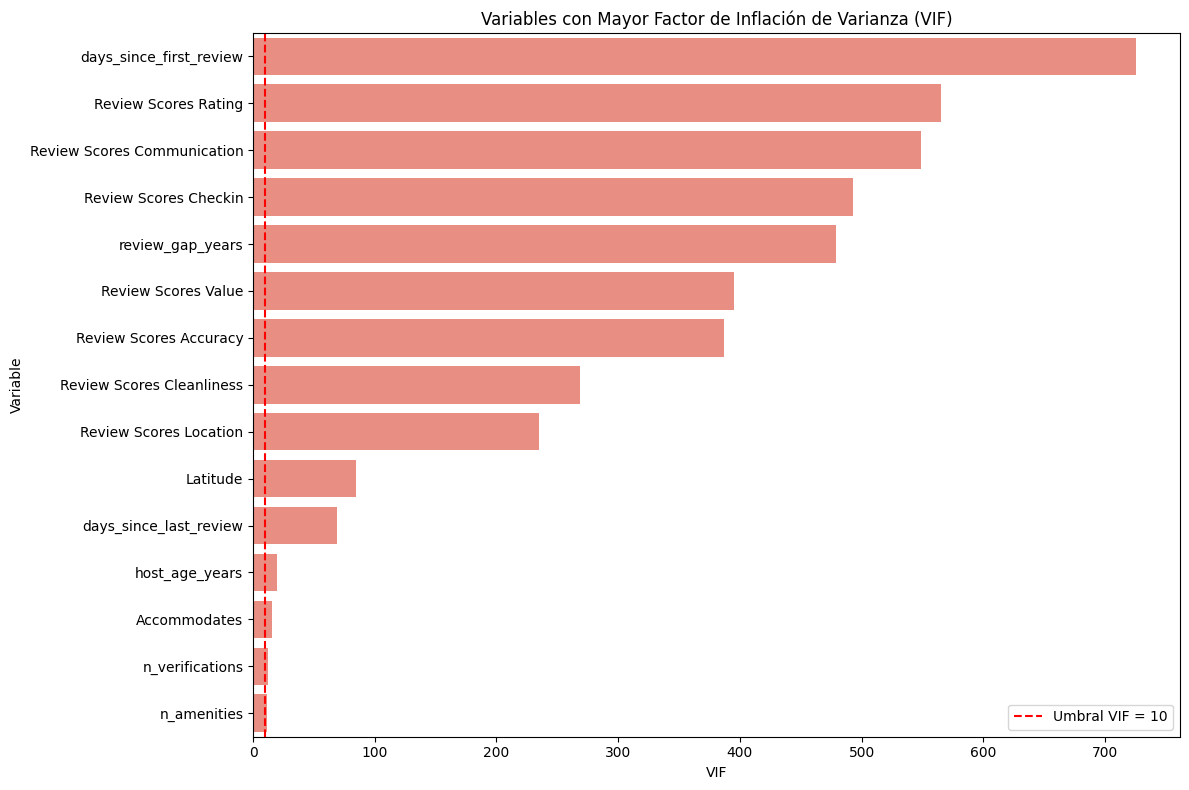

Variables con VIF > 10:
['days_since_first_review', 'Review Scores Rating', 'Review Scores Communication', 'Review Scores Checkin', 'review_gap_years', 'Review Scores Value', 'Review Scores Accuracy', 'Review Scores Cleanliness', 'Review Scores Location', 'Latitude', 'days_since_last_review', 'host_age_years', 'Accommodates', 'n_verifications', 'n_amenities', 'Beds']


In [45]:
# Seleccionar top 15 VIF
vif_top = vif_data.sort_values('VIF', ascending=False).head(15).copy()

# Asegurar que Variable sea string para graficar
vif_top['Variable'] = vif_top['Variable'].astype(str)

# Gráfico
plt.figure(figsize=(12, 8))
sns.barplot(
    data=vif_top,
    x='VIF',
    y='Variable',
    color='salmon'  # ← un solo color, evita el warning
)

# Líneas y etiquetas
plt.title('Variables con Mayor Factor de Inflación de Varianza (VIF)')
plt.axvline(x=10, color='red', linestyle='--', label='Umbral VIF = 10')
plt.xlabel('VIF')
plt.ylabel('Variable')
plt.legend()
plt.tight_layout()
plt.show()

# Mostrar variables con VIF > 10
high_vif_vars = vif_data[vif_data['VIF'] > 10]['Variable'].tolist()
print("Variables con VIF > 10:")
print(high_vif_vars)

In [46]:
df_filtered = df_filtered.copy()

# --- Índice de capacidad ---
cap_cols = ['Accommodates', 'Beds', 'Bedrooms']

if all(col in df_filtered.columns for col in cap_cols):
    cap_data = df_filtered[cap_cols].fillna(0)
    cap_scaled = MinMaxScaler().fit_transform(cap_data)
    df_filtered['capacity_index'] = cap_scaled.mean(axis=1)
    df_filtered.drop(columns=cap_cols, inplace=True)
    print(f"Índice 'capacity_index' creado y eliminadas: {cap_cols}")

# --- Índice de reseñas (fechas) ---
review_cols = ['days_since_first_review', 'days_since_last_review', 'review_gap_years']

if all(col in df_filtered.columns for col in review_cols):
    review_data = df_filtered[review_cols].fillna(
        df_filtered[review_cols].median(numeric_only=True)
    )
    review_scaled = MinMaxScaler().fit_transform(review_data)
    df_filtered['review_index'] = PCA(n_components=1, random_state=SEED).fit_transform(review_scaled)
    df_filtered.drop(columns=review_cols, inplace=True)
    print(f"Índice 'review_index' creado y eliminadas: {review_cols}")


# --- Índice del host ---
host_cols = ['host_age_years', 'n_verifications', 'n_amenities']

if all(col in df_filtered.columns for col in host_cols):
    host_data = df_filtered[host_cols].fillna(
        df_filtered[host_cols].median(numeric_only=True)
    )
    host_scaled = MinMaxScaler().fit_transform(host_data)
    df_filtered['host_index'] = PCA(n_components=1, random_state=SEED).fit_transform(host_scaled)
    df_filtered.drop(columns=host_cols, inplace=True)
    print(f"Índice 'host_index' creado y eliminadas: {host_cols}")

Índice 'capacity_index' creado y eliminadas: ['Accommodates', 'Beds', 'Bedrooms']
Índice 'review_index' creado y eliminadas: ['days_since_first_review', 'days_since_last_review', 'review_gap_years']
Índice 'host_index' creado y eliminadas: ['host_age_years', 'n_verifications', 'n_amenities']


In [47]:
# Seleccionando solo columnas numéricas
X = df_filtered.select_dtypes(include='number')

# Excluyendo la variable objetivo si está presente
X = X.drop(columns=['Price'], errors='ignore')

# Imputando valores faltantes con la mediana
X = X.fillna(X.median(numeric_only=True))

In [48]:
# Calcular VIF
vif_data_final = pd.DataFrame()
vif_data_final['Variable'] = X.columns
vif_data_final['VIF'] = [
    variance_inflation_factor(X.values, i) for i in range(X.shape[1])
]

# Ordenar de mayor a menor VIF
vif_data_final = vif_data_final.sort_values("VIF", ascending=False).reset_index(drop=True)

In [49]:
# Mostrar resultado
display(vif_data_final)

,Variable,VIF
0,Review Scores Rating,561.720726
1,Review Scores Communication,545.251258
2,Review Scores Checkin,491.150834
3,Review Scores Accuracy,368.935019
4,Review Scores Value,331.381176
5,Review Scores Cleanliness,254.232652
6,Review Scores Location,224.277678
7,Latitude,80.719185
8,Host ID,9.262684
9,Calculated host listings count,7.888735


In [50]:
# Consolidar review_scores si no se ha hecho
review_score_cols = [
    'Review Scores Rating', 'Review Scores Accuracy', 'Review Scores Cleanliness',
    'Review Scores Checkin', 'Review Scores Communication',
    'Review Scores Location', 'Review Scores Value'
]

# Filtrar solo las columnas que existen en df_filtered
review_score_cols = [col for col in review_score_cols if col in df_filtered.columns]

# Consolidar si hay columnas disponibles
if review_score_cols:
    df_filtered['review_scores_mean'] = df_filtered[review_score_cols].mean(axis=1)
    df_filtered.drop(columns=review_score_cols, inplace=True)
    print(f"Consolidado 'review_scores_mean' (eliminadas {len(review_score_cols)} columnas)")

Consolidado 'review_scores_mean' (eliminadas 7 columnas)


In [51]:
cols_to_remove = ['Latitude', 'Host ID']

# Filtrar solo las columnas que existen en el DataFrame
existing_cols = [col for col in cols_to_remove if col in df_filtered.columns]

# Eliminar si existen
if existing_cols:
    df_filtered.drop(columns=existing_cols, inplace=True)
    print(f"Columnas eliminadas: {existing_cols}")

Columnas eliminadas: ['Latitude', 'Host ID']


In [52]:
# Recalculando VIF
# Selección de variables numéricas, excluyendo target y transformaciones
X = df_filtered.select_dtypes(include='number').drop(
    columns=['Price', 'Price_log'], errors='ignore'
)

# Imputación de valores faltantes con la mediana
X = X.fillna(X.median(numeric_only=True))

# Cálculando el VIF
vif_data_final = pd.DataFrame()
vif_data_final['Variable'] = X.columns
vif_data_final['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Ordenando el resultado
vif_data_final = vif_data_final.sort_values("VIF", ascending=False).reset_index(drop=True)

# Mostrar
print("\nVIF final tras consolidación de Review Scores y limpieza de columnas redundantes:")
display(vif_data_final)


VIF final tras consolidación de Review Scores y limpieza de columnas redundantes:


,Variable,VIF
0,review_scores_mean,10.541536
1,Calculated host listings count,7.844581
2,Host Listings Count,7.419343
3,Bathrooms,6.936614
4,Reviews per Month,4.998359
5,Number of Reviews,4.778512
6,Guests Included,4.531648
7,capacity_index,4.347184
8,Availability 365,3.597849
9,Cleaning Fee,3.088311


El análisis del VIF final muestra que la variable review_scores_mean presenta una colinealidad considerablemente alta, con un VIF superior a 10, lo cual sugiere una redundancia significativa con otras variables del conjunto y podría afectar la estabilidad de modelos lineales. Aunque no sobrepasan el umbral crítico, también destacan Calculated host listings count y Host Listings Count con valores de VIF cercanos a 8 y 7.4 respectivamente, lo que indica una relación fuerte entre sí, probablemente derivada de una dependencia estructural o duplicidad en la forma de calcular la cantidad de propiedades por anfitrión.

El resto de las variables presentan VIFs moderados a bajos, lo cual sugiere una adecuada independencia lineal entre ellas. Variables como Bathrooms, Reviews per Month, Number of Reviews y Guests Included tienen VIFs cercanos a 5, lo que es aceptable en muchos contextos, aunque podrían ser monitoreadas si se busca un modelo muy parsimonioso. Por otro lado, variables como host_index, review_index, Longitude, Minimum Nights y Maximum Nights tienen VIFs cercanos a 1, lo que indica muy baja colinealidad y por tanto buena estabilidad para modelado. En conjunto, el dataset muestra un buen equilibrio tras la limpieza y consolidación, aunque convendría evaluar la permanencia de review_scores_mean o explorar su relación con otras variables para evitar posibles distorsiones en la interpretación de los coeficientes.

Revisamos la distribución de 'Price' (variable objetivo) para evaluar si es necesario transformarla antes del modelado

In [53]:
# Estadísticas básicas y asimetría
price_stats = df_filtered['Price'].describe()
original_skew = df_filtered['Price'].skew()

print("\nEstadísticas de 'Price' antes de transformación logarítmica:")
print(price_stats)
print(f"Asimetría (skew) original: {original_skew:.2f}")


Estadísticas de 'Price' antes de transformación logarítmica:
count    14632.000000
mean        72.514762
std         69.973607
min          9.000000
25%         34.000000
50%         55.000000
75%         85.000000
max        999.000000
Name: Price, dtype: float64
Asimetría (skew) original: 4.46


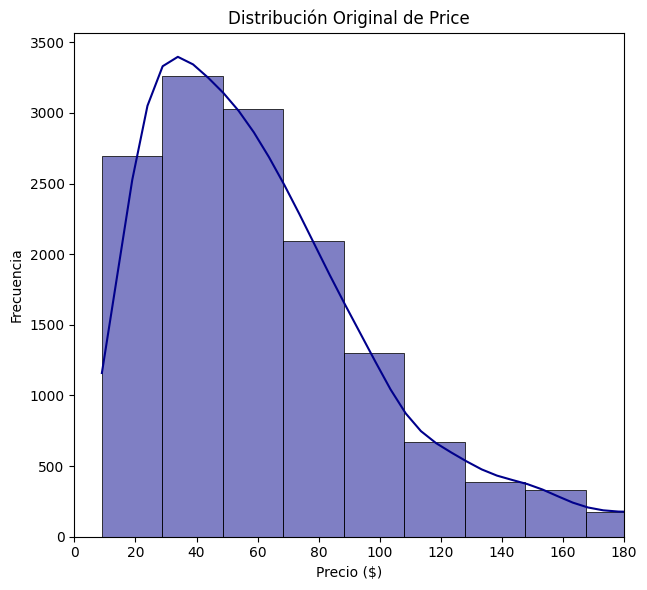

In [54]:
# Visualización de distribución original y transformada

plt.figure(figsize=(18, 6))

# Histograma original
plt.subplot(1, 3, 1)
sns.histplot(df_filtered['Price'], bins=50, kde=True, color='darkblue')
plt.title('Distribución Original de Price')
plt.xlabel('Precio ($)')
plt.ylabel('Frecuencia')
plt.xlim(0, df_filtered['Price'].quantile(0.95))  # Limita el eje x al percentil 95 para mejor visualización

plt.tight_layout()
plt.show()

(0.0, 180.0)

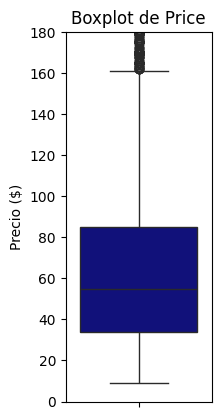

In [55]:
# Boxplot original
plt.subplot(1, 3, 2)
sns.boxplot(y=df_filtered['Price'], color='darkblue')
plt.title('Boxplot de Price')
plt.ylabel('Precio ($)')
plt.ylim(0, df_filtered['Price'].quantile(0.95))  # Limita el eje y para excluir outliers extremos

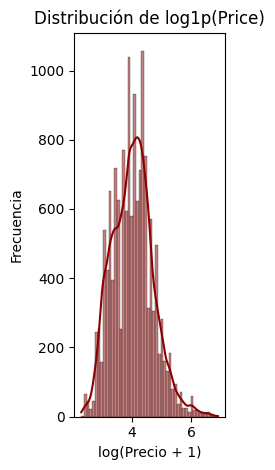

In [56]:
# Histograma transformado
plt.subplot(1, 3, 3)
sns.histplot(np.log1p(df_filtered['Price']), bins=50, kde=True, color='darkred')
plt.title('Distribución de log1p(Price)')
plt.xlabel('log(Precio + 1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()


Asimetría después de transformación: 0.37
Reducción de asimetría: 4.09


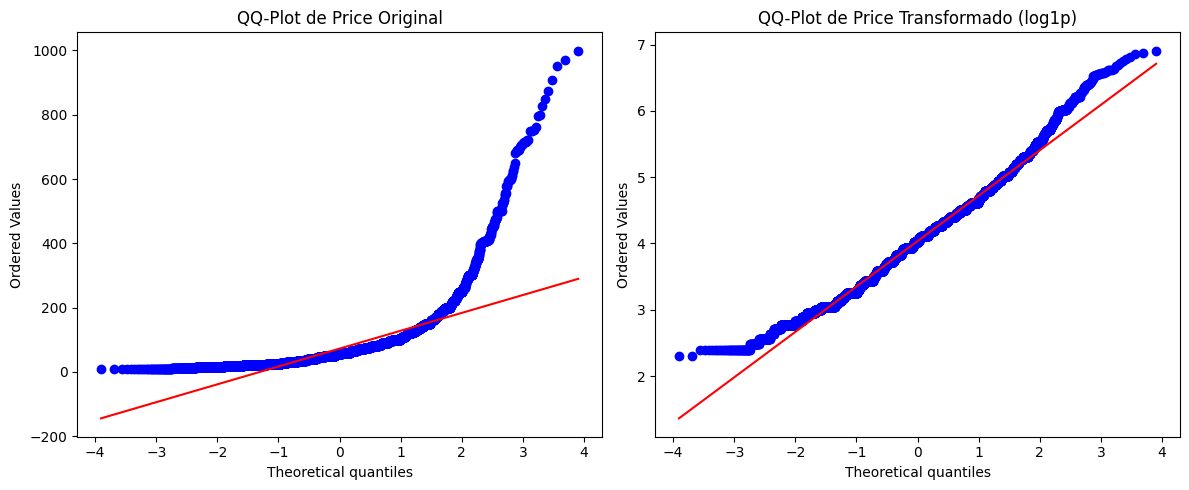

In [57]:
# Aplicamos log1p para evitar log(0)
df_filtered['Price_log'] = np.log1p(df_filtered['Price'])

# Verificamos la nueva asimetría
log_skew = df_filtered['Price_log'].skew()
print(f"\nAsimetría después de transformación: {log_skew:.2f}")
print("Reducción de asimetría:", round(original_skew - log_skew, 2))

# QQ-Plots para comparar la normalidad

from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(df_filtered['Price'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot de Price Original')

plt.subplot(1, 2, 2)
stats.probplot(df_filtered['Price_log'].dropna(), dist="norm", plot=plt)
plt.title('QQ-Plot de Price Transformado (log1p)')

plt.tight_layout()
plt.show()

La variable 'Price' tenía alta asimetría y fue transformada con log1p para aproximarla a una distribución normal. Esto mejora el desempeño de modelos lineales y reduce el impacto de valores extremos.

## Transformación de Precio con log1p()

La variable `Price` presentaba una distribución fuertemente asimétrica (asimetría: 4.37), lo cual es común en precios donde hay muchos valores bajos y pocos extremadamente altos. 

Para mejorar su comportamiento estadístico y facilitar el aprendizaje de los modelos (especialmente lineales), aplicamos una transformación logarítmica (`log1p`).

**Resultados:**
- La asimetría bajó de 4.37 a 0.39
- La distribución se volvió mucho más simétrica
- El QQ-plot posterior muestra una clara alineación con la normal

Esta transformación reduce el impacto de valores extremos y mejora la estabilidad y desempeño del modelo predictivo.

In [58]:
# Verificando que Price y Price_log están altamente correlacionadas
if all(col in df_filtered.columns for col in ['Price', 'Price_log']):
    correlation = df_filtered[['Price', 'Price_log']].corr().iloc[0, 1]
    print(f"Correlación entre Price y Price_log: {correlation:.4f}")

Correlación entre Price y Price_log: 0.8409


Esto confirma que la transformación logarítmica conserva la estructura del precio original

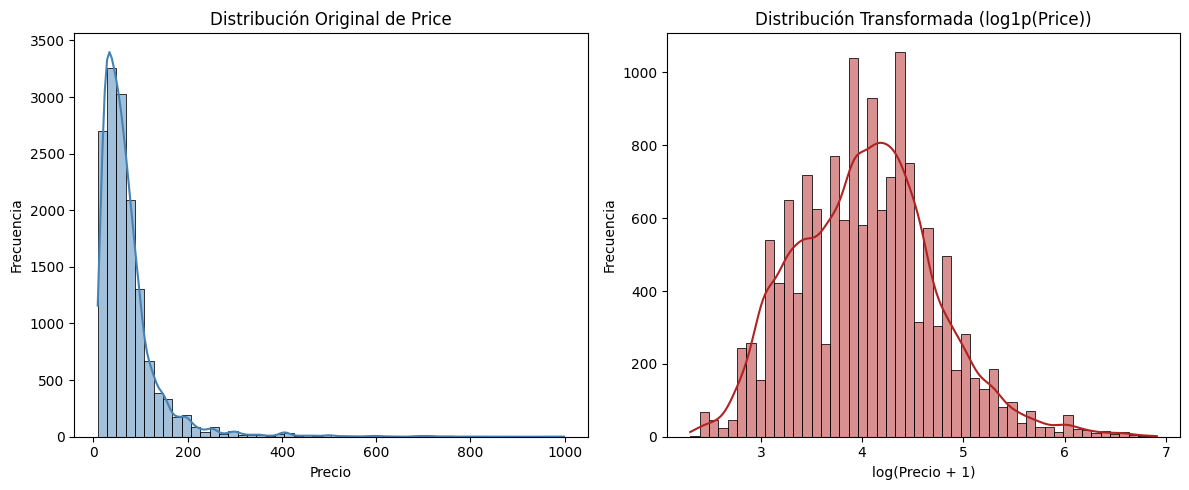

In [59]:
# Comparando visualmente las distribuciones antes y después de la transformación
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(df_filtered['Price'], kde=True, bins=50, color='steelblue')
plt.title('Distribución Original de Price')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')

plt.subplot(1, 2, 2)
sns.histplot(df_filtered['Price_log'], kde=True, bins=50, color='firebrick')
plt.title('Distribución Transformada (log1p(Price))')
plt.xlabel('log(Precio + 1)')
plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [60]:
# Evaluando si hay otras variables numéricas con alta asimetría (skew)
numeric_cols = df_filtered.select_dtypes(include='number').columns

# Inicialización
skewed_cols = []

# Cálculo de asimetría, excluyendo Price y Price_log
for col in numeric_cols:
    if col in ['Price', 'Price_log']:
        continue
    skewness = df_filtered[col].skew()
    if abs(skewness) > 1:
        skewed_cols.append((col, skewness))

# Resultados ordenados
skewed_df = pd.DataFrame(skewed_cols, columns=['Variable', 'Asimetría']).sort_values('Asimetría', ascending=False)

print("\nVariables numéricas con alta asimetría (|skew| > 1):")
display(skewed_df)


Variables numéricas con alta asimetría (|skew| > 1):


,Variable,Asimetría
6,Maximum Nights,112.256527
5,Minimum Nights,61.432999
4,Extra People,10.122354
2,Cleaning Fee,7.666488
0,Host Listings Count,4.552946
8,Calculated host listings count,4.211003
3,Guests Included,3.582392
1,Bathrooms,3.395045
7,Number of Reviews,3.173075
10,capacity_index,2.284499


In [61]:
# Variables que transformaremos con log1p
log_transform_cols = [
    'Maximum Nights',
    'Minimum Nights',
    'Extra People',
    'Cleaning Fee',
    'Number of Reviews',
    'Reviews per Month'
]

# Crear nuevas columnas con sufijo _log si existen en el DataFrame
for col in log_transform_cols:
    if col in df_filtered.columns:
        df_filtered[col + '_log'] = np.log1p(df_filtered[col])
        print(f"Transformado {col} → {col}_log")

# Mostrar las nuevas columnas transformadas (si existen)
cols_log = [col + '_log' for col in log_transform_cols if col + '_log' in df_filtered.columns]
df_filtered[cols_log].head()

Transformado Maximum Nights → Maximum Nights_log
Transformado Minimum Nights → Minimum Nights_log
Transformado Extra People → Extra People_log
Transformado Cleaning Fee → Cleaning Fee_log
Transformado Number of Reviews → Number of Reviews_log
Transformado Reviews per Month → Reviews per Month_log


,Maximum Nights_log,Minimum Nights_log,Extra People_log,Cleaning Fee_log,Number of Reviews_log,Reviews per Month_log
0,7.026427,1.098612,0.000000,3.258097,3.761200,1.504077
1,7.026427,0.693147,3.806662,3.713572,0.693147,0.620576
2,7.026427,0.693147,3.761200,4.110874,0.000000,0.788457
3,7.026427,1.098612,3.688879,4.382027,2.639057,0.737164
4,7.026427,1.098612,0.000000,4.025352,0.000000,0.788457


## Transformación logarítmica de variables altamente sesgadas

Varias variables presentaban distribuciones fuertemente asimétricas (skew > 1), lo cual puede afectar el desempeño de modelos sensibles a la forma de las variables.

Aplicamos `log1p()` a las siguientes variables para suavizar su distribución y reducir el impacto de valores extremos:
- Maximum Nights
- Minimum Nights
- Extra People
- Cleaning Fee
- Number of Reviews
- Reviews per Month

Se crearon nuevas columnas con sufijo `_log` que serán evaluadas en el modelado.

In [62]:
pd.set_option('display.max_columns', None)

In [88]:
df_filtered.drop(columns='Price', inplace=True)
df_filtered.head(3)

,Name,Host Name,Host Location,Host Response Time,Host Response Rate,Host Neighbourhood,Host Listings Count,Street,Neighbourhood,Neighbourhood Cleansed,Neighbourhood Group Cleansed,City,State,Zipcode,Market,Smart Location,Country Code,Country,Longitude,Property Type,Room Type,Bathrooms,Bed Type,Cleaning Fee,Guests Included,Extra People,Minimum Nights,Maximum Nights,Calendar Updated,Availability 365,Number of Reviews,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features,capacity_index,review_index,host_index,review_scores_mean,Price_log,Maximum Nights_log,Minimum Nights_log,Extra People_log,Cleaning Fee_log,Number of Reviews_log,Reviews per Month_log
0,The Loft-Full Bath-Deck w/View,John,My father was USAF so I was born at Offutt AFB...,within an hour,100.0,,1.0,"Canyon Edge Drive, Austin, TX 78733, United St...",,78733,,Austin,TX,78733,Austin,"Austin, TX",US,United States,-97.863277,Loft,Entire home/apt,1.0,Real Bed,25.0,1.0,0.0,2.0,1125.0,today,281.0,42.0,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id...",0.055556,-0.035545,-0.157769,22.571429,4.077537,7.026427,1.098612,0.000000,3.258097,3.761200,1.504077
1,"Claris I, Friendly Rentals",Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08010, Spain",,la Dreta de l'Eixample,Eixample,Barcelona,Barcelona,08010,Barcelona,"Barcelona, Spain",ES,Spain,2.172625,Apartment,Entire home/apt,1.0,Real Bed,40.0,2.0,44.0,1.0,1125.0,today,309.0,1.0,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ...",0.100000,-0.231410,-0.280864,19.428571,4.262680,7.026427,0.693147,3.806662,3.713572,0.693147,0.620576
2,"Style Terrace Red, Friendly Rentals",Claudia,"Barcelona, Catalonia, Spain",within an hour,100.0,,162.0,"Barcelona, Barcelona 08008, Spain",,la Dreta de l'Eixample,Eixample,Barcelona,Barcelona,08008,Barcelona,"Barcelona, Spain",ES,Spain,2.162173,Apartment,Entire home/apt,1.0,Real Bed,60.0,2.0,42.0,1.0,1125.0,today,291.0,0.0,super_strict_30,106.0,1.20,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ...",0.100000,-0.057726,-0.280864,21.857143,4.262680,7.026427,0.693147,3.761200,4.110874,0.000000,0.788457


In [89]:
# Muestro un ejemplo de cómo se ve el precio ahora
sample_prices = pd.DataFrame({
    'Price_Original': [50, 100, 200, 500, 1000],
    'Price_Log': np.log1p([50, 100, 200, 500, 1000])
})
print("\nEjemplo de transformación para algunos precios:")
display(sample_prices)


Ejemplo de transformación para algunos precios:


,Price_Original,Price_Log
0,50,3.931826
1,100,4.615121
2,200,5.303305
3,500,6.216606
4,1000,6.908755


CODIFICACIÓN DE VARIABLES CATEGÓRICAS

In [90]:
# Crear una copia del dataframe base para codificación
df_encoded = df_filtered.copy()

# Columnas categóricas a excluir manualmente (irrelevantes o con cardinalidad alta esperada)
excluir_cols = [
    'Name', 'Host Name', 'Street', 'Host Location', 'Zipcode', 'Geolocation',
    'Smart Location', 'Country', 'Country Code', 'Market', 'Host Neighbourhood'
]

# Detectar columnas categóricas que sí queremos evaluar
cat_cols = df_encoded.select_dtypes(include='object').columns.tolist()
cat_cols = [col for col in cat_cols if col not in excluir_cols]

print(f"Detectadas {len(cat_cols)} columnas categóricas útiles (excluidas {len(excluir_cols)} irrelevantes):")
display(pd.DataFrame({
    'Columna': cat_cols,
    'Valores Únicos': [df_encoded[col].nunique() for col in cat_cols],
    'Ejemplo': [df_encoded[col].dropna().iloc[0] if df_encoded[col].notna().any() else 'NaN' for col in cat_cols]
}).sort_values('Valores Únicos'))

# Separar columnas con baja y alta cardinalidad
one_hot_cols = [col for col in cat_cols if df_encoded[col].nunique() <= 10]
high_card_cols = [col for col in cat_cols if df_encoded[col].nunique() > 10]

print(f"\nColumnas para One-Hot Encoding ({len(one_hot_cols)}): {one_hot_cols}")
print(f"Columnas descartadas por alta cardinalidad ({len(high_card_cols)}): {high_card_cols}")

# Aplicar One-Hot Encoding (sin afectar df_clean)
df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)

# Eliminar columnas de alta cardinalidad (solo si no se van a codificar)
df_encoded.drop(columns=high_card_cols, inplace=True, errors='ignore')

print(f"\nDimensiones finales del df_encoded: {df_encoded.shape}")
print("Ejemplo de nuevas columnas dummy creadas:")
print([col for col in df_encoded.columns if any(prefix in col for prefix in one_hot_cols)][:10])

Detectadas 13 columnas categóricas útiles (excluidas 11 irrelevantes):


,Columna,Valores Únicos,Ejemplo
8,Room Type,3,Entire home/apt
0,Host Response Time,5,within an hour
9,Bed Type,5,Real Bed
11,Cancellation Policy,8,moderate
7,Property Type,22,Loft
4,Neighbourhood Group Cleansed,49,
10,Calendar Updated,57,today
1,Host Response Rate,70,100.0
12,Features,89,"Host Is Superhost,Host Has Profile Pic,Host Id..."
6,State,103,TX



Columnas para One-Hot Encoding (4): ['Host Response Time', 'Room Type', 'Bed Type', 'Cancellation Policy']
Columnas descartadas por alta cardinalidad (9): ['Host Response Rate', 'Neighbourhood', 'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City', 'State', 'Property Type', 'Calendar Updated', 'Features']

Dimensiones finales del df_encoded: (14632, 51)
Ejemplo de nuevas columnas dummy creadas:
['Host Response Time_unknown', 'Host Response Time_within a day', 'Host Response Time_within a few hours', 'Host Response Time_within an hour', 'Room Type_Private room', 'Room Type_Shared room', 'Bed Type_Couch', 'Bed Type_Futon', 'Bed Type_Pull-out Sofa', 'Bed Type_Real Bed']


ESCALADO DE VARIABLES Y PREPARACIÓN FINAL

In [91]:
# Definir variable objetivo
y = df_encoded['Price_log']

# Crear copia del dataset
df_model_scaled = df_encoded.copy()

# Identificar columnas numéricas a escalar (excluyendo Price_log)
numeric_cols = df_model_scaled.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != 'Price_log']

# Aplicar StandardScaler
scaler = StandardScaler()
df_model_scaled[numeric_cols] = scaler.fit_transform(df_model_scaled[numeric_cols])

# Guardar el scaler para usarlo en datos futuros
joblib.dump(scaler, 'scaler.pkl')
print("Escalador guardado como 'scaler.pkl'")

Escalador guardado como 'scaler.pkl'


In [92]:
# Separar X e y
y = df_encoded['Price_log']
X = df_encoded.drop(columns='Price_log')

# Identificar columnas numéricas dentro de X
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Seleccionar un subconjunto de variables numéricas para visualizar
variables_to_plot = numeric_cols[:3]  # Puedes ajustar este número

print(f"Variables numéricas seleccionadas para visualización: {variables_to_plot}")

Variables numéricas seleccionadas para visualización: ['Host Listings Count', 'Longitude', 'Bathrooms']


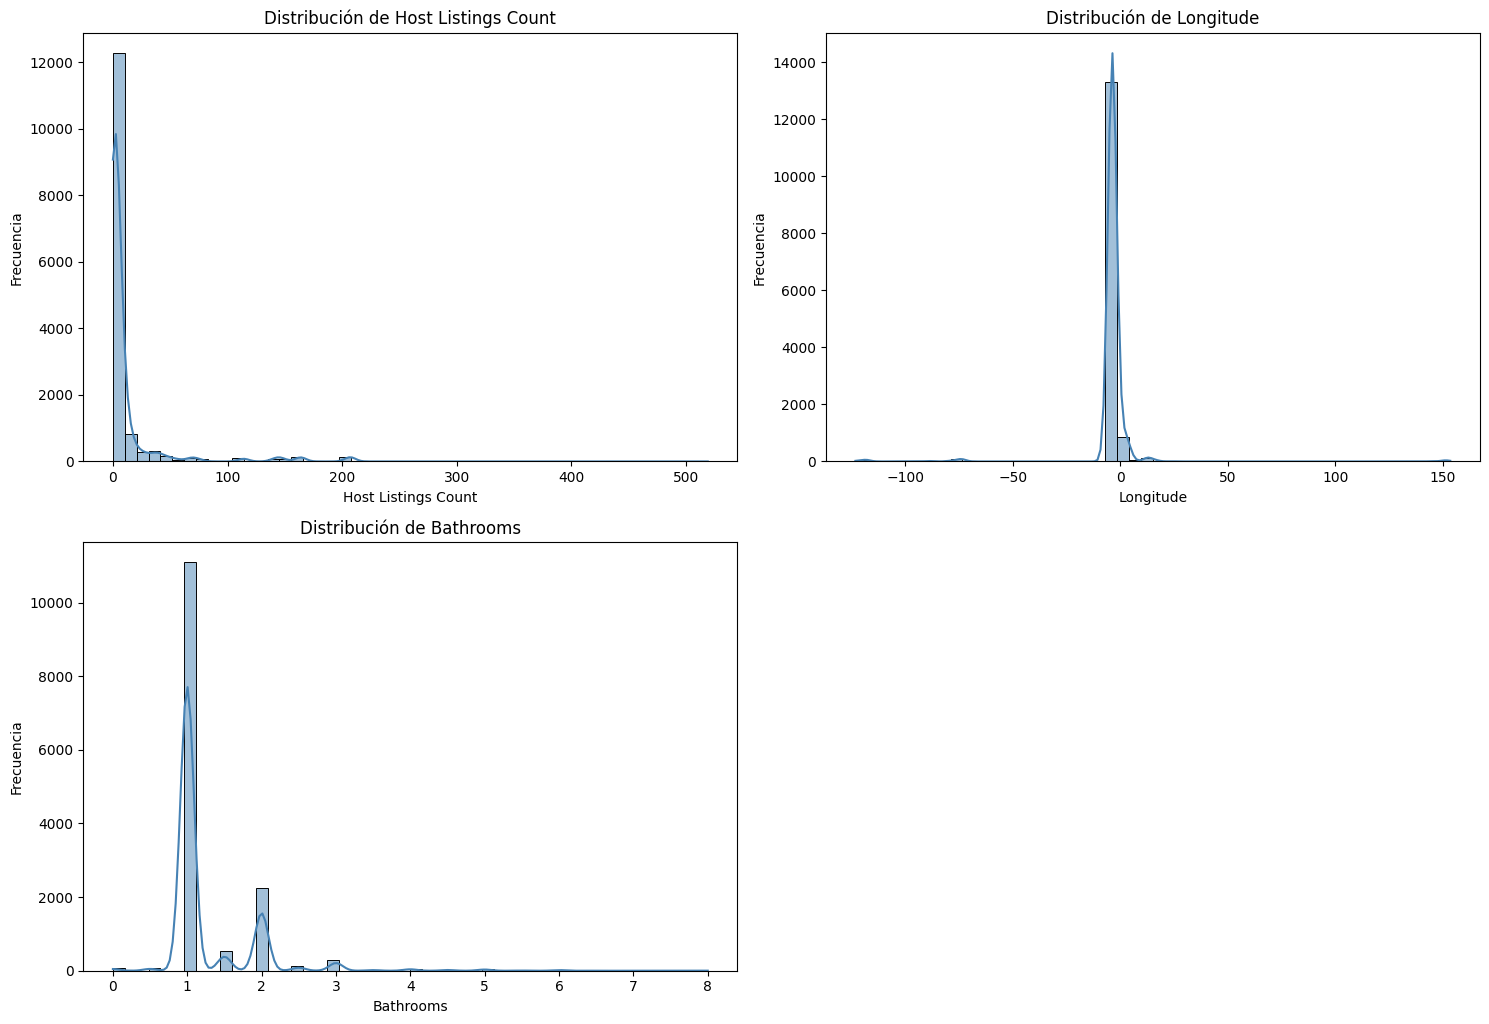

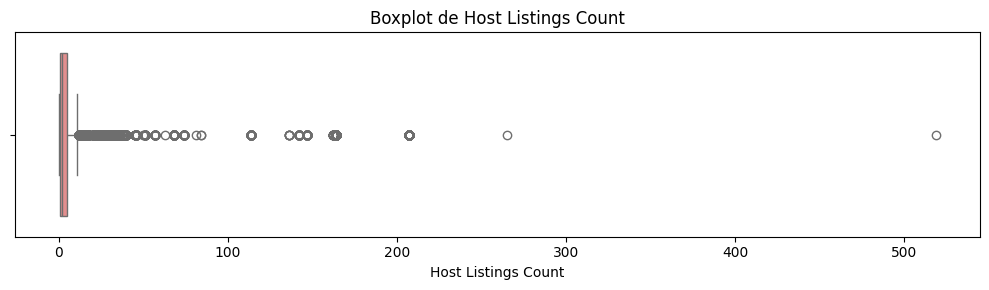

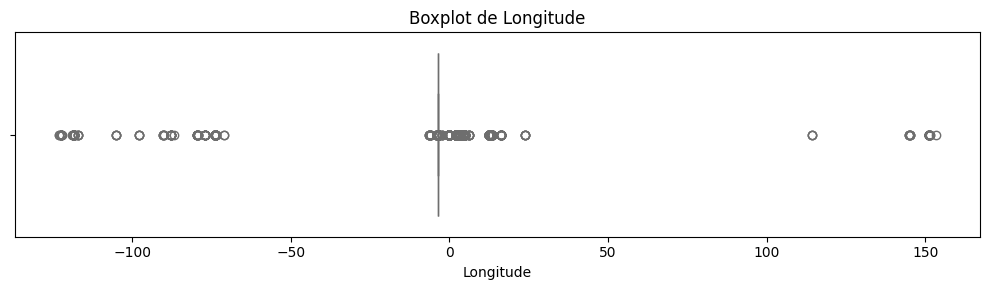

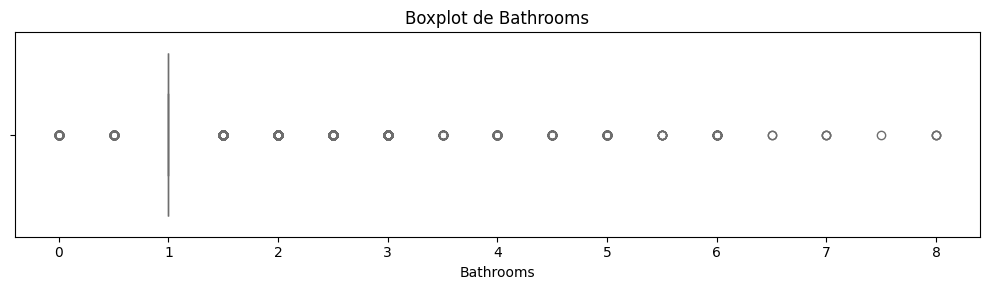

In [93]:
# Histograma y KDE para las variables seleccionadas
plt.figure(figsize=(15, 5 * len(variables_to_plot)))
for i, var in enumerate(variables_to_plot, 1):
    plt.subplot(len(variables_to_plot), 2, i)
    sns.histplot(X[var], bins=50, kde=True, color='steelblue')
    plt.title(f'Distribución de {var}')
    plt.xlabel(var)
    plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# Boxplots para observar outliers y dispersión
for var in variables_to_plot:
    plt.figure(figsize=(10, 3))
    sns.boxplot(x=X[var], color='lightcoral')
    plt.title(f'Boxplot de {var}')
    plt.tight_layout()
    plt.show()

Antes del escalado, todas las variables tenían rangos muy diferentes entre sí. Por ejemplo, Cleaning Fee podía ir desde 0 hasta más de 600 dólares, mientras que Guests Included normalmente no pasaba de 4 o 5 personas, y Bathrooms tenía una distribución muy marcada en valores discretos (1, 1.5, 2, etc.). Esto genera un desbalance cuando se usan modelos que interpretan la magnitud de los valores numéricos (como regresiones o redes neuronales).

Después del escalado, todas las variables ahora están centradas y estandarizadas en torno a cero, con una dispersión mucho más comparable. Aunque los outliers siguen estando allí (porque el escalado no los elimina, solo ajusta la escala), su peso relativo se normaliza frente al resto de los datos. Esto es bueno, porque evita que una sola variable con un rango grande como Cleaning Fee domine el aprendizaje del modelo.

También se nota que el shape general de las distribuciones no cambió: seguimos teniendo picos, colas y outliers. Lo que cambió fue la escala, y eso es exactamente lo que queríamos.

EVALUACIÓN FINAL DEL DATAFRAME

In [94]:
# Dimensiones del DataFrame
print(f"\nTamaño del DataFrame: {df_encoded.shape[0]} filas, {df_encoded.shape[1]} columnas")


Tamaño del DataFrame: 14632 filas, 51 columnas


In [95]:
# Tipos de datos
print("\nTipos de datos por tipo:")
print(df_encoded.dtypes.value_counts())


Tipos de datos por tipo:
float64    23
uint8      17
object     11
dtype: int64


In [71]:
# Conteo de variables numéricas (excluyendo la target)
num_vars = df_encoded.select_dtypes(include='number').shape[1] - (1 if 'Price_log' in df_encoded.columns else 0)
print(f"Cantidad de variables numéricas predictoras: {num_vars}")

Cantidad de variables numéricas predictoras: 40


In [107]:
df_encoded.isna().sum()

Name                                     0
Host Name                                0
Host Location                            0
Host Neighbourhood                       0
Host Listings Count                      0
Street                                   0
Zipcode                                  0
Market                                   0
Smart Location                           0
Country Code                             0
Country                                  0
Longitude                                0
Bathrooms                                0
Cleaning Fee                             0
Guests Included                          0
Extra People                             0
Minimum Nights                           0
Maximum Nights                           0
Availability 365                         0
Number of Reviews                        0
Calculated host listings count           0
Reviews per Month                        0
Geolocation                              0
capacity_in

In [108]:
df_encoded.isna().any(axis=1).sum()

0

In [96]:
# Estadísticas descriptivas de las variables numéricas
print("\nEstadísticas descriptivas:")
display(df_encoded.describe().T)


Estadísticas descriptivas:


,count,mean,std,min,25%,50%,75%,max
Host Listings Count,14632.0,1.169867e+01,32.439948,0.000000,1.000000,2.000000,5.000000,519.000000
Longitude,14632.0,-3.862065e+00,13.987748,-123.131344,-3.707596,-3.700810,-3.684605,153.371427
Bathrooms,14632.0,1.267257e+00,0.624639,0.000000,1.000000,1.000000,1.000000,8.000000
Cleaning Fee,14632.0,2.875410e+01,22.889696,0.000000,20.000000,25.000000,30.000000,662.000000
Guests Included,14632.0,1.572034e+00,1.112928,0.000000,1.000000,1.000000,2.000000,16.000000
Extra People,14632.0,7.627597e+00,12.674939,0.000000,0.000000,0.000000,14.000000,500.000000
Minimum Nights,14632.0,3.011208e+00,12.194335,1.000000,1.000000,2.000000,3.000000,1125.000000
Maximum Nights,14632.0,9.448457e+02,8481.820468,1.000000,365.000000,1125.000000,1125.000000,1000000.000000
Availability 365,14632.0,2.019242e+02,127.884902,0.000000,78.000000,238.000000,319.000000,365.000000
Number of Reviews,14632.0,2.282873e+01,38.429707,0.000000,1.000000,7.000000,27.000000,446.000000


In [97]:
# Correlación con la variable objetivo
if 'Price_log' in df_encoded.columns:
    corr_matrix = df_encoded.corr(numeric_only=True)['Price_log'].drop('Price_log').sort_values(ascending=False)
    
    print("\nVariables más correlacionadas con Price_log:")
    display(corr_matrix.head(10))

    print("\nVariables menos correlacionadas con Price_log:")
    display(corr_matrix.tail(10))


Variables más correlacionadas con Price_log:


capacity_index                    0.564571
Cleaning Fee_log                  0.479887
Cleaning Fee                      0.420668
Guests Included                   0.368352
Bathrooms                         0.259353
Host Listings Count               0.224078
Calculated host listings count    0.208054
Cancellation Policy_strict        0.158915
Minimum Nights_log                0.139913
host_index                        0.139659
Name: Price_log, dtype: float64


Variables menos correlacionadas con Price_log:


Longitude                         -0.018059
Host Response Time_within a day   -0.022825
Bed Type_Pull-out Sofa            -0.023891
Cancellation Policy_moderate      -0.025125
Bed Type_Futon                    -0.032331
Reviews per Month_log             -0.035135
Reviews per Month                 -0.043300
Host Response Time_unknown        -0.058108
Room Type_Shared room             -0.147337
Room Type_Private room            -0.616859
Name: Price_log, dtype: float64

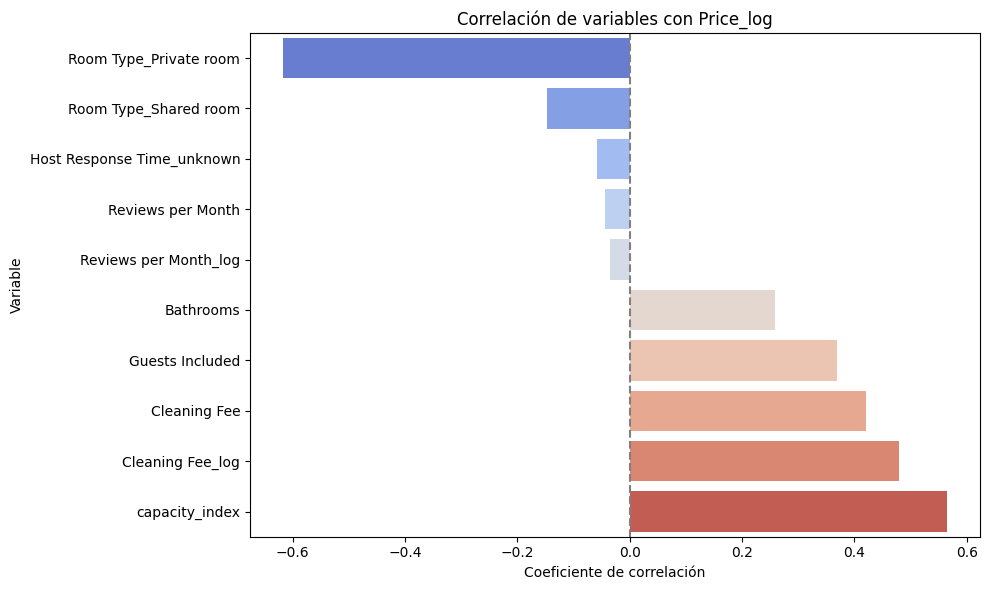

In [98]:
# generando mapa de correlaciones entre las variables

if 'Price_log' in df_encoded.columns:
    # Calcular correlación con Price_log
    corr_matrix = df_encoded.corr(numeric_only=True)['Price_log'].drop('Price_log').sort_values()

    # Tomar las 5 más negativas y 5 más positivas
    top_negative = corr_matrix.head(5)
    top_positive = corr_matrix.tail(5)
    combined = pd.concat([top_negative, top_positive])

    # Crear DataFrame para graficar
    corr_plot_df = combined.reset_index()
    corr_plot_df.columns = ['Variable', 'Correlacion']

    # Visualización sin warning
    plt.figure(figsize=(10, 6))
    sns.barplot(data=corr_plot_df, x='Correlacion', y='Variable', hue='Variable', palette='coolwarm', dodge=False, legend=False)
    plt.title("Correlación de variables con Price_log")
    plt.xlabel("Coeficiente de correlación")
    plt.axvline(0, color='gray', linestyle='--')
    plt.tight_layout()
    plt.show()

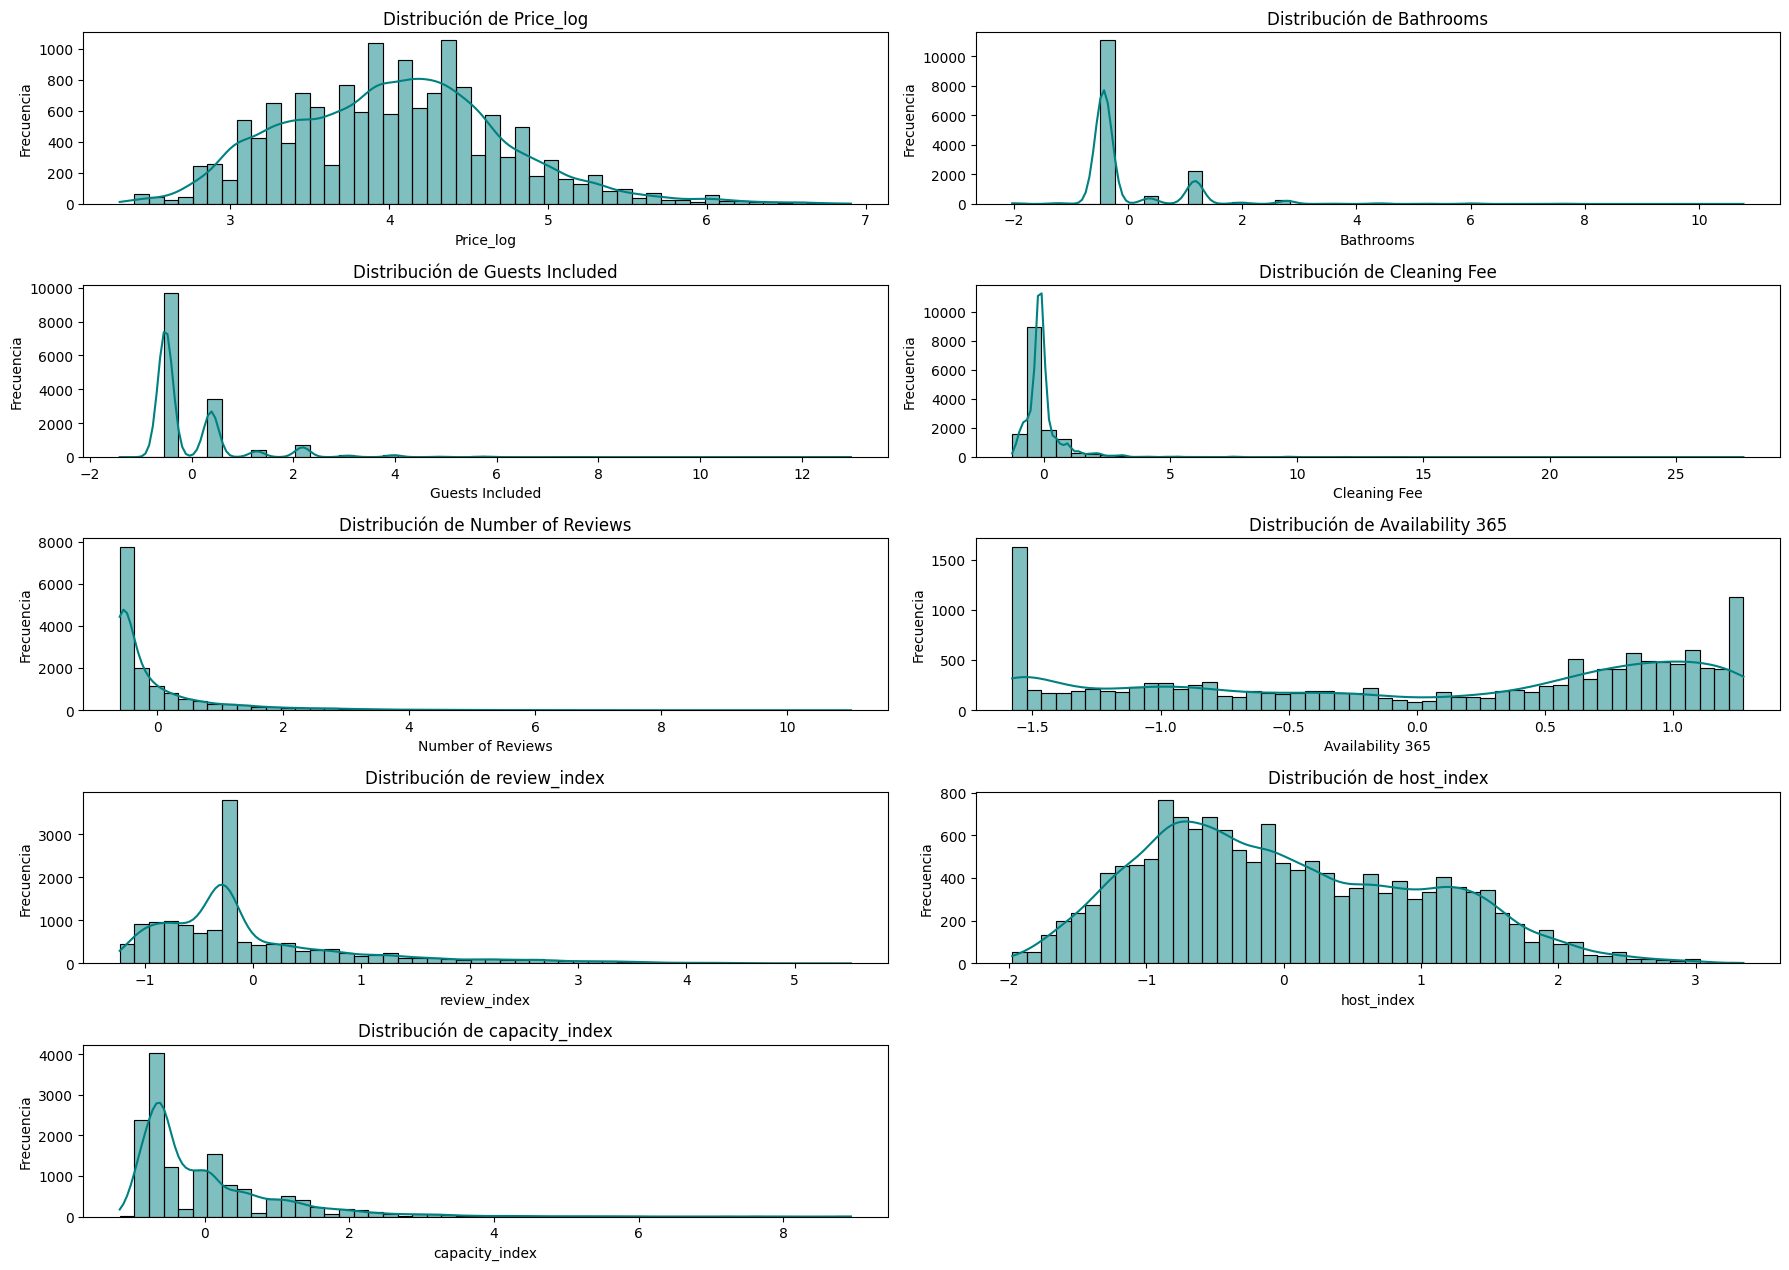

In [99]:
# Variables clave (ajusta según tu df_model_scaled)
key_vars = [
    'Price_log', 'Bathrooms', 'Guests Included', 'Cleaning Fee',
    'Number of Reviews', 'Availability 365',
    'review_index', 'host_index', 'capacity_index'
]

# Filtrar solo las que existen en el dataset
key_vars = [col for col in key_vars if col in df_model_scaled.columns]

# Histogramas
plt.figure(figsize=(18, len(key_vars) * 2.5))
for i, col in enumerate(key_vars):
    plt.subplot(len(key_vars), 2, i + 1)
    sns.histplot(df_model_scaled[col], kde=True, bins=50, color='teal')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.show()

Las gráficas muestran la distribución de las variables más importantes que alimentarán el modelo. Aquí algunas observaciones clave:
	•	Price_log ya presenta una distribución mucho más simétrica y cercana a una normal, lo cual es excelente como variable objetivo para modelos lineales.
	•	Bathrooms, Guests Included, Cleaning Fee y Number of Reviews siguen teniendo colas derechas marcadas, pero al estar escaladas, su magnitud ya no distorsiona el modelo. Si bien hay outliers, ahora están balanceados en la escala estandarizada.
	•	Availability 365 tiene una distribución interesante: parece casi uniforme, con picos en los extremos. Esto indica que hay propiedades que están o casi siempre disponibles o casi nunca. El modelo puede aprovechar esta información para asociarla a precios.
	•	Los índices compuestos (review_index, host_index, capacity_index) capturan bastante variabilidad. Aunque todavía tienen algo de asimetría, esto es esperable al haber sido generados con componentes principales o combinaciones de variables originales.


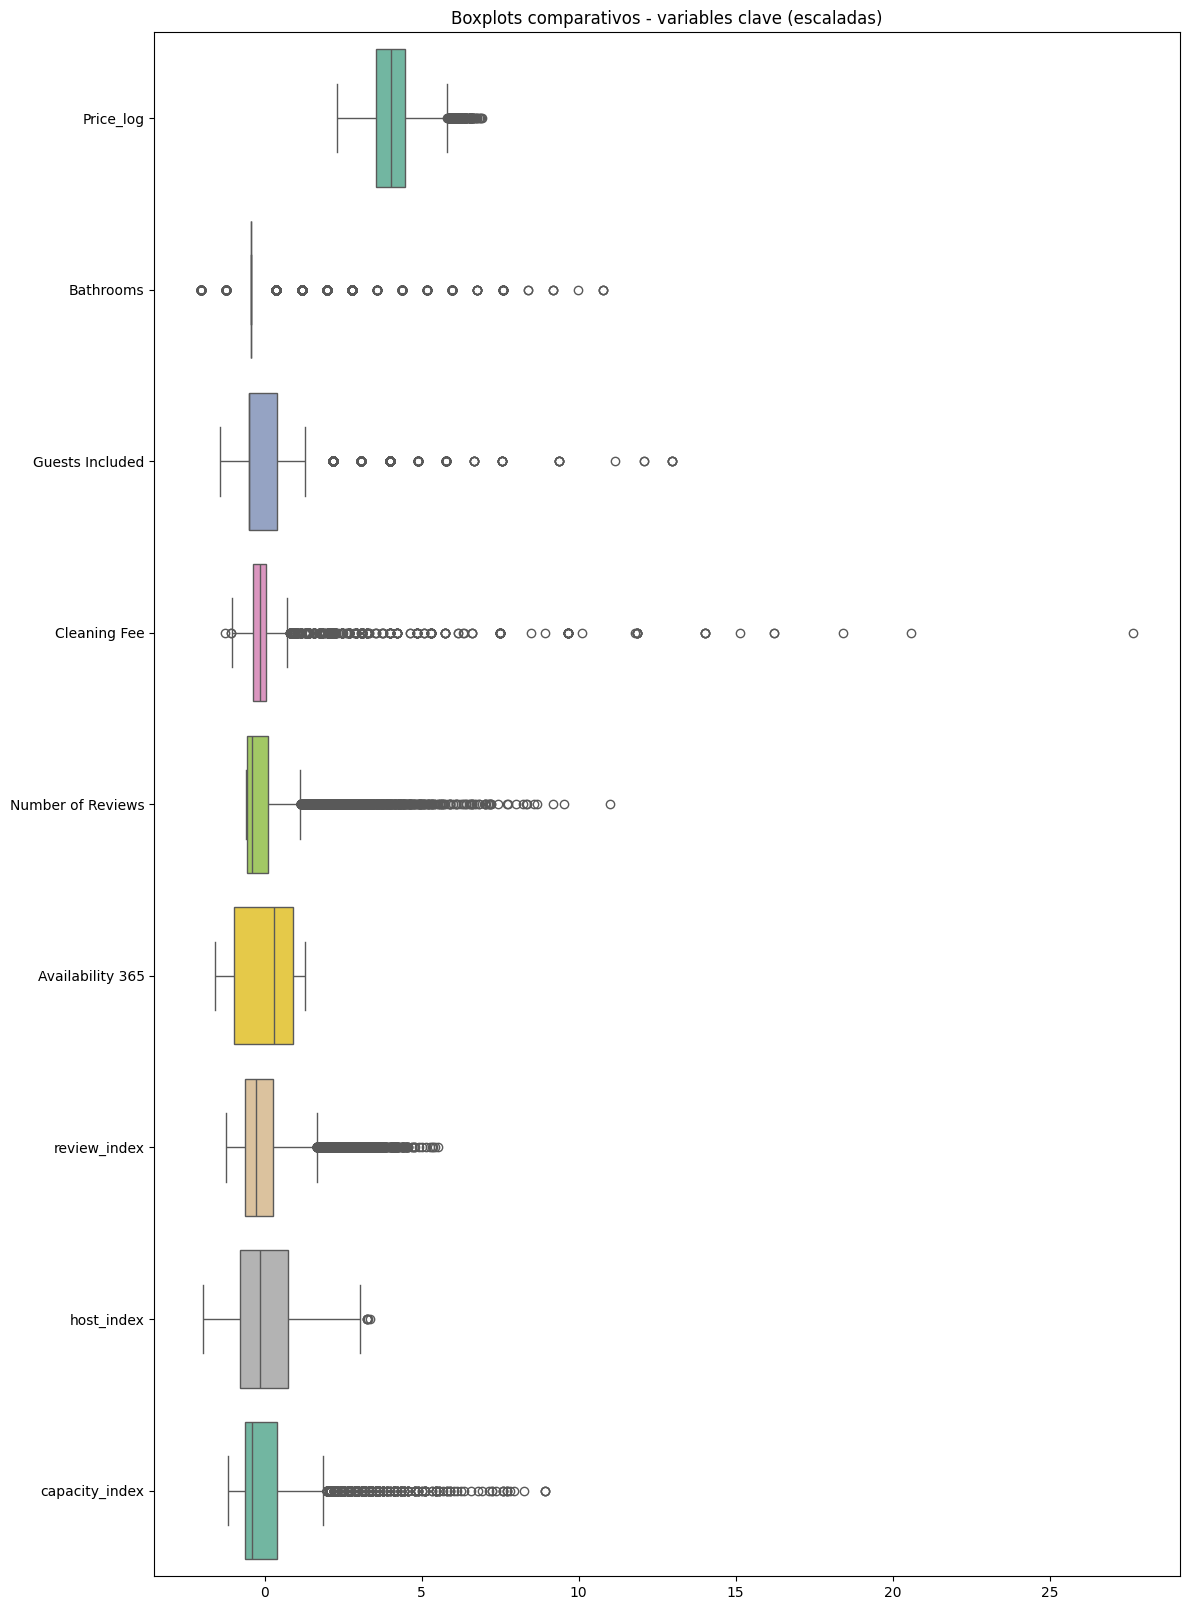

In [100]:
plt.figure(figsize=(12, 1.8 * len(key_vars)))
sns.boxplot(data=df_model_scaled[key_vars], orient='h', palette='Set2')
plt.title("Boxplots comparativos - variables clave (escaladas)")
plt.tight_layout()
plt.show()

Los boxplots comparativos de las variables escaladas muestran varias cosas importantes para validar la preparación del dataset antes del modelado:
- Price_log, que será nuestra variable objetivo, muestra una dispersión controlada y una concentración clara en valores medios. Su forma es consistente con una distribución logarítmica normalizada, lista para modelado.
- Variables como Guests Included, Cleaning Fee, Number of Reviews y capacity_index tienen colas largas con presencia de outliers. Esto no es un problema en sí, ya que fueron estandarizadas, pero sí indica que hay usuarios o propiedades atípicas que podrían influir en modelos sensibles a valores extremos (como regresiones sin regularización).
- Availability 365 se ve mucho más balanceada, con una distribución casi uniforme. Este patrón tiene sentido, ya que algunos anuncios están disponibles todo el año y otros solo ocasionalmente.
- Los índices compuestos como host_index, review_index y capacity_index, aunque aún muestran valores atípicos, tienen una escala controlada gracias al uso de técnicas como PCA y escalado estándar.

In [101]:
cwd = Path.cwd()
print("Working dir:", cwd)

Working dir: /Users/gonzalezulises/Documents/GitHub/airbnb-pricing-ml/notebooks


In [102]:
project_root = cwd.parent

In [103]:
out_dir = project_root / "data" / "clean" / "processed"
out_dir.mkdir(parents=True, exist_ok=True)

In [104]:
out_path = out_dir / "df_model.csv"

In [105]:
df_encoded.to_csv(out_path, index=False)
print(f"Dataset final guardado en: {out_path}")

Dataset final guardado en: /Users/gonzalezulises/Documents/GitHub/airbnb-pricing-ml/data/clean/processed/df_model.csv
